In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time

from jax.numpy import fft

from tqdm import tqdm

In [2]:
from jax import jit, grad, vmap, hessian, value_and_grad
import optax

In [3]:
def discrete_sine_transform(y):
    n = y.shape[0] +1
    y_extended = jnp.concatenate([y, jnp.array([0]), -y[::-1]])
    y_fft = fft.rfft(y_extended)
    return (-y_fft.imag/(jnp.sqrt(2)*(n)))[:-1]

In [4]:
# Define the neural network
def init_params(layer_sizes, key):
    params = []
    keys = random.split(key, len(layer_sizes))
    for m, n, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        weights = random.normal(key, (m, n)) * jnp.sqrt(2 / m)
        biases = jnp.zeros(n)
        params.append((weights, biases))
    return params

def predict(params, x):
    activations = x
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

In [5]:
def count_parameters(params):
    total_params = 0
    for weights, biases in params:
        total_params += weights.size
        total_params += biases.size
    return total_params

# Using the DST for solving an elliptic PDE

We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\nu\Delta u + u &= \xi \\
u &= 0
\end{aligned}


If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2} + 1\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Conversely, if 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty \xi_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

then 

$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)} \sin\Big(\frac{n\pi x}{L}\Big)
$$

Iou casem we will have the domain be $[0,1]$ and so $L = 1.0$. Therefore

\begin{aligned}
\xi &=   \sqrt{2} \sum_{i}^\infty \xi_i \sin\Big(n\pi x\Big) \\
u &=  \sqrt{2}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)}\sin\Big(n\pi x\Big)
\end{aligned}

Our solution will be found using a NN.


In [6]:
def evaluate_function_sine(x, k ,c):
    return c*jnp.sqrt(2)*jnp.sin(jnp.pi*k*x)
def evaluate_basis_sine(x,c):
    frequencies = jnp.arange(1, c.shape[0]+1)
    return jnp.sum(vmap(evaluate_function_sine, in_axes=(0,None,None))(x, frequencies, c), axis=1)

In [7]:
plt.style.use('plot_style-Examples.txt')
#plt.style.use('default')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

In [8]:
key = random.PRNGKey(635)
nu = 0.01
n_coef = 2**14
upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(upper,lower,n_coef+1)
print(n_coef)

frequencies = jnp.arange(1, n_coef+1)
coef_f = random.normal(key, shape= (n_coef,))
coef_u = coef_f/(nu*frequencies**2*jnp.pi**2 + 1)

f_values = evaluate_basis_sine(domain_finest, coef_f)
u_values = evaluate_basis_sine(domain_finest, coef_u)

16384


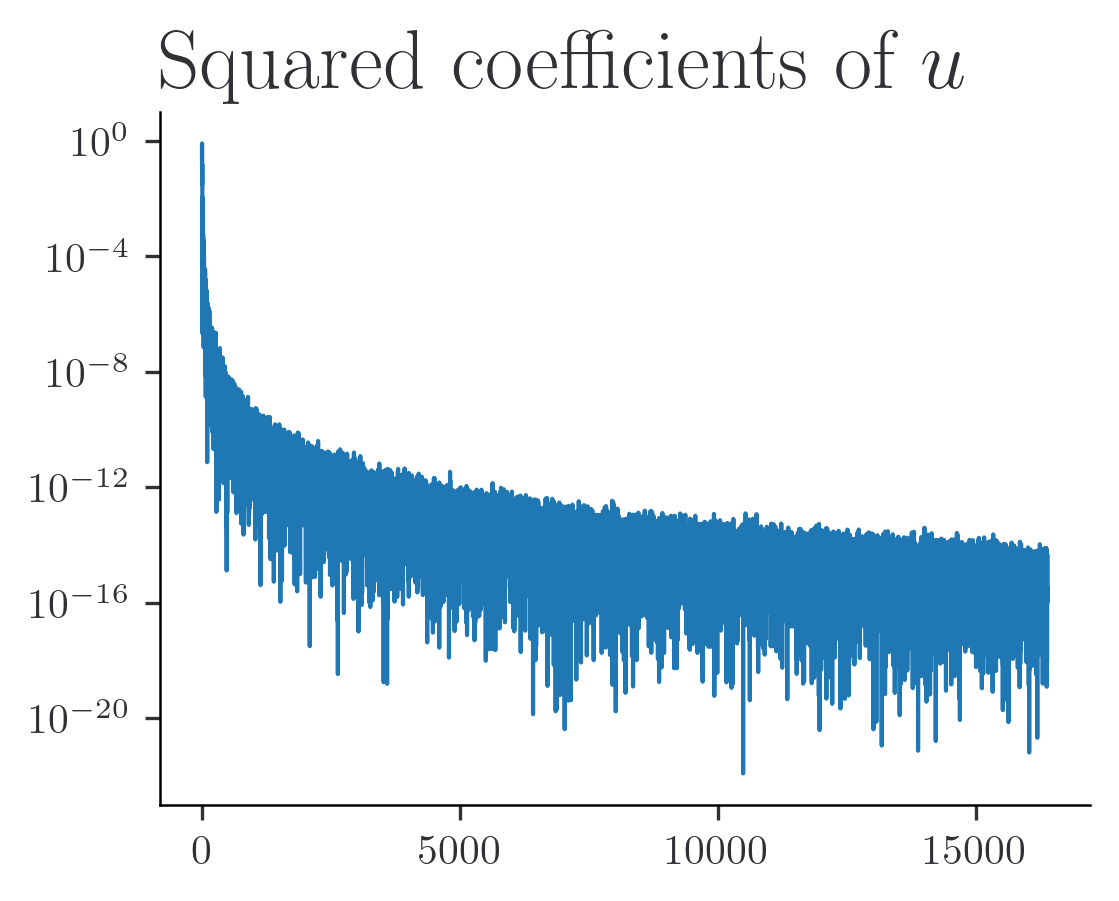

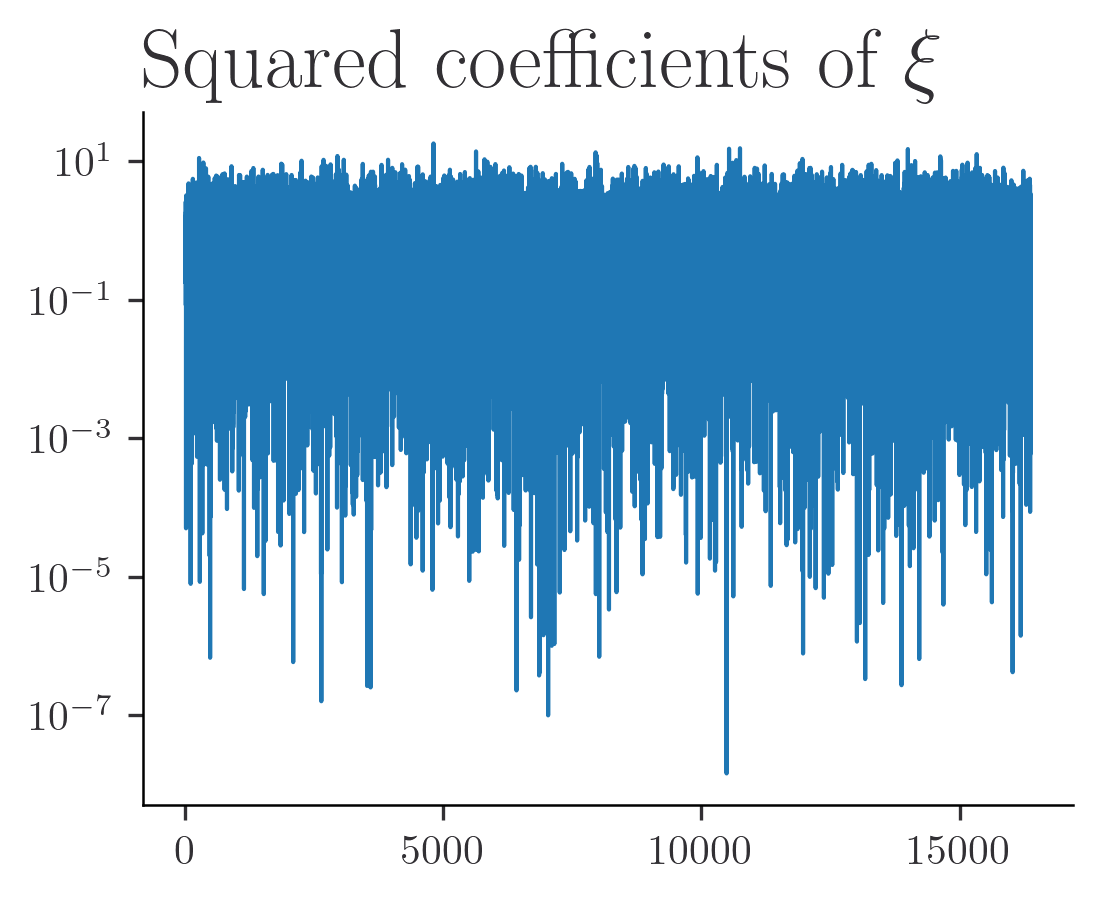

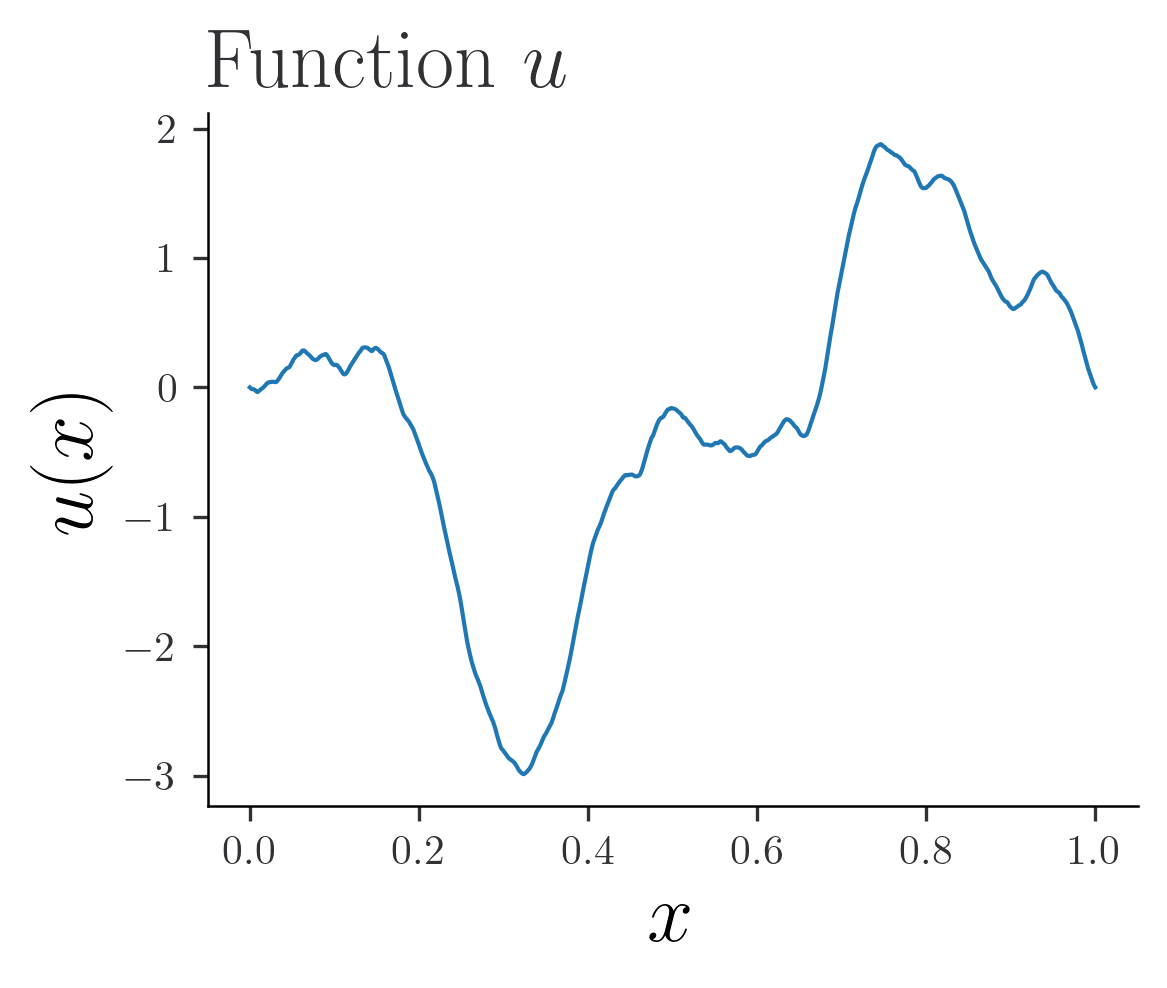

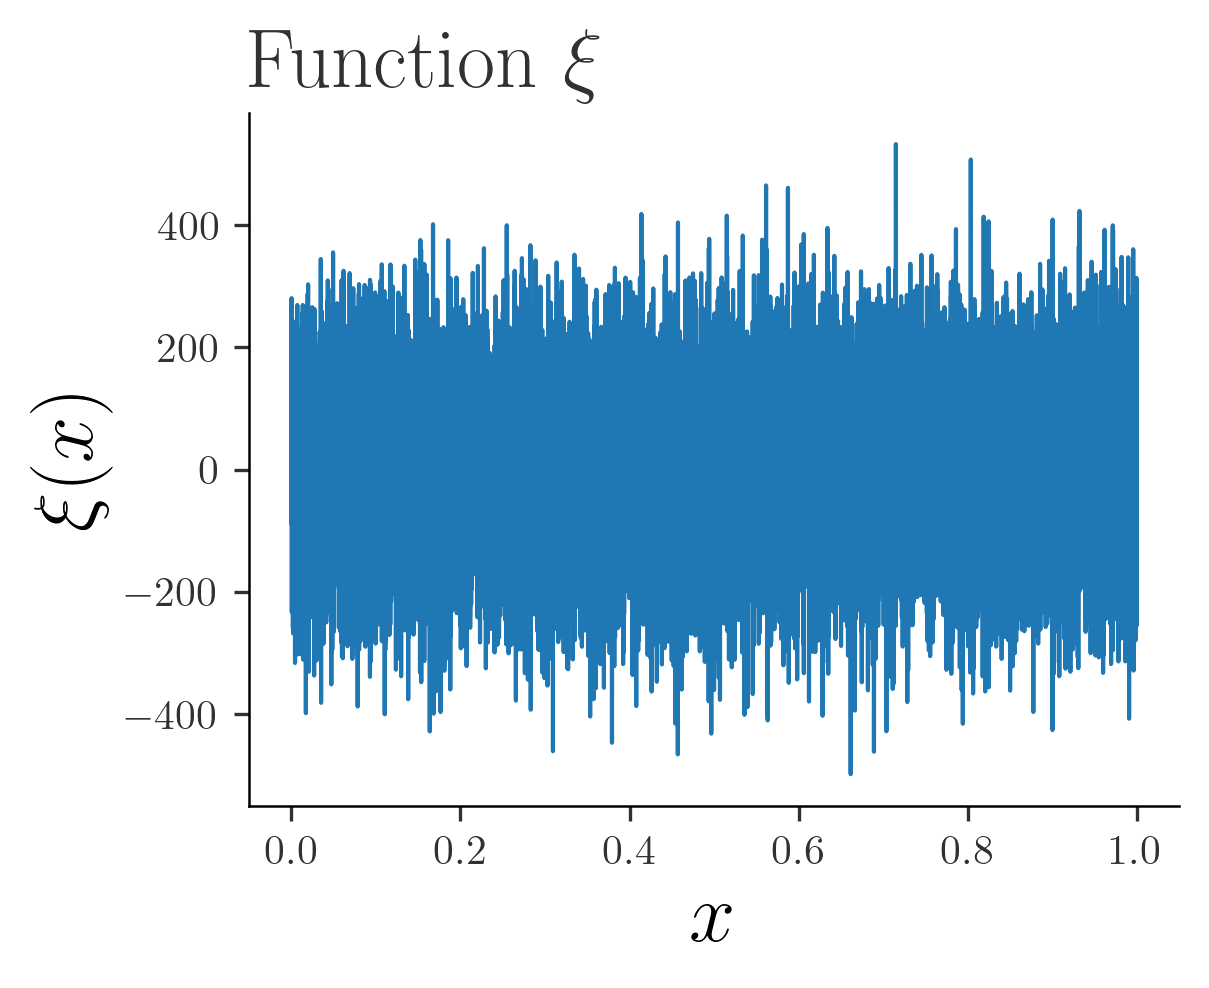

In [9]:
# Plot both the coeffients of u and f in 2 subplots
fig = plt.figure(figsize=(width, height))
plt.plot(coef_u**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $u$')


plt.show()

fig = plt.figure(figsize=(width, height))
plt.plot(coef_f**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $\xi$')
plt.show()

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, u_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")

fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, f_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$\xi(x)$")
plt.title(r"Function $\xi$")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

# PINN 4096 measurements (unweighted norm)

In [11]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1)
domain_measurements.shape

4096


(4097,)

In [12]:
layer_sizes = [1, 128, 128,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = discrete_sine_transform(-nu*laplacian_grid + u_grid)[1:]
    residual_interior = (pred_sine - f)

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 16897 parameters in the neural network.


In [13]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, coef_f[:n_meas],boundary_conditions, nu)
print(loss, grads)

() ()
(4097,) (4097,)
1.2259015162102425 [(Array([[ 7.24431546e-02,  1.10416975e-03,  5.60426550e-03,
         4.87605650e-03,  1.76010236e-02, -1.35140646e-03,
        -2.47748319e-02,  1.56806639e-01,  3.48670157e-02,
         3.12585130e-04, -1.35701944e-01,  8.45198173e-02,
        -1.06742148e-02,  7.56434427e-04,  4.09483198e-02,
         1.66340968e-02, -5.21628005e-02,  1.39972179e-01,
        -1.26944737e-01,  1.37082384e-04,  8.44119519e-02,
        -3.72071781e-02,  2.25639807e-02, -1.29216601e-01,
        -6.99052634e-03, -2.27423689e-02, -8.09436385e-03,
        -4.32666691e-02, -9.86582287e-02,  8.27162617e-02,
         6.34072750e-02,  9.19354400e-02, -8.30017789e-03,
        -6.32518354e-03, -3.06360616e-03, -7.44746147e-03,
        -3.92401231e-03, -1.25330601e-03, -2.25576041e-02,
        -1.36028529e-02, -6.70559432e-03,  4.41817328e-03,
         1.64459390e-03, -1.29460630e-02,  8.29567714e-04,
         7.44666557e-03, -1.86589125e-02, -1.28266707e-02,
         1.55

In [14]:
# Define the optimizer
optimizer = optax.adamw(1e-3, weight_decay = 0.0)
opt_state = optimizer.init(params)

In [15]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, coef_f[:n_meas],boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [16]:
patience = 1000  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0
loss_hist = []
num_epochs = 3e5
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 1.2259015
Epoch 10000, Loss: 0.9756776
Epoch 20000, Loss: 0.9623056
Epoch 30000, Loss: 0.9517390
Epoch 40000, Loss: 0.9371282
Epoch 50000, Loss: 0.9307481
Epoch 60000, Loss: 0.9264082
Epoch 70000, Loss: 0.9238508
Epoch 80000, Loss: 0.9209192
Epoch 90000, Loss: 0.9196555
Epoch 100000, Loss: 0.9183642
Epoch 110000, Loss: 0.9132796
Epoch 120000, Loss: 0.9121182
Epoch 130000, Loss: 0.9103177
Epoch 140000, Loss: 0.9090973
Epoch 150000, Loss: 0.9075073
Epoch 160000, Loss: 0.9051080
Epoch 170000, Loss: 0.9034568
Epoch 180000, Loss: 0.9021663
Epoch 190000, Loss: 0.9013054
Epoch 200000, Loss: 0.8997540
Epoch 210000, Loss: 0.8989912
Epoch 220000, Loss: 0.8985597
Epoch 230000, Loss: 0.8983223
Epoch 240000, Loss: 0.8985011
Epoch 250000, Loss: 0.8988573
Epoch 260000, Loss: 0.8972618
Epoch 270000, Loss: 0.8969747
Epoch 280000, Loss: 0.8966552
Epoch 290000, Loss: 0.8963205


In [17]:
pred = neural_network(params, domain_finest)

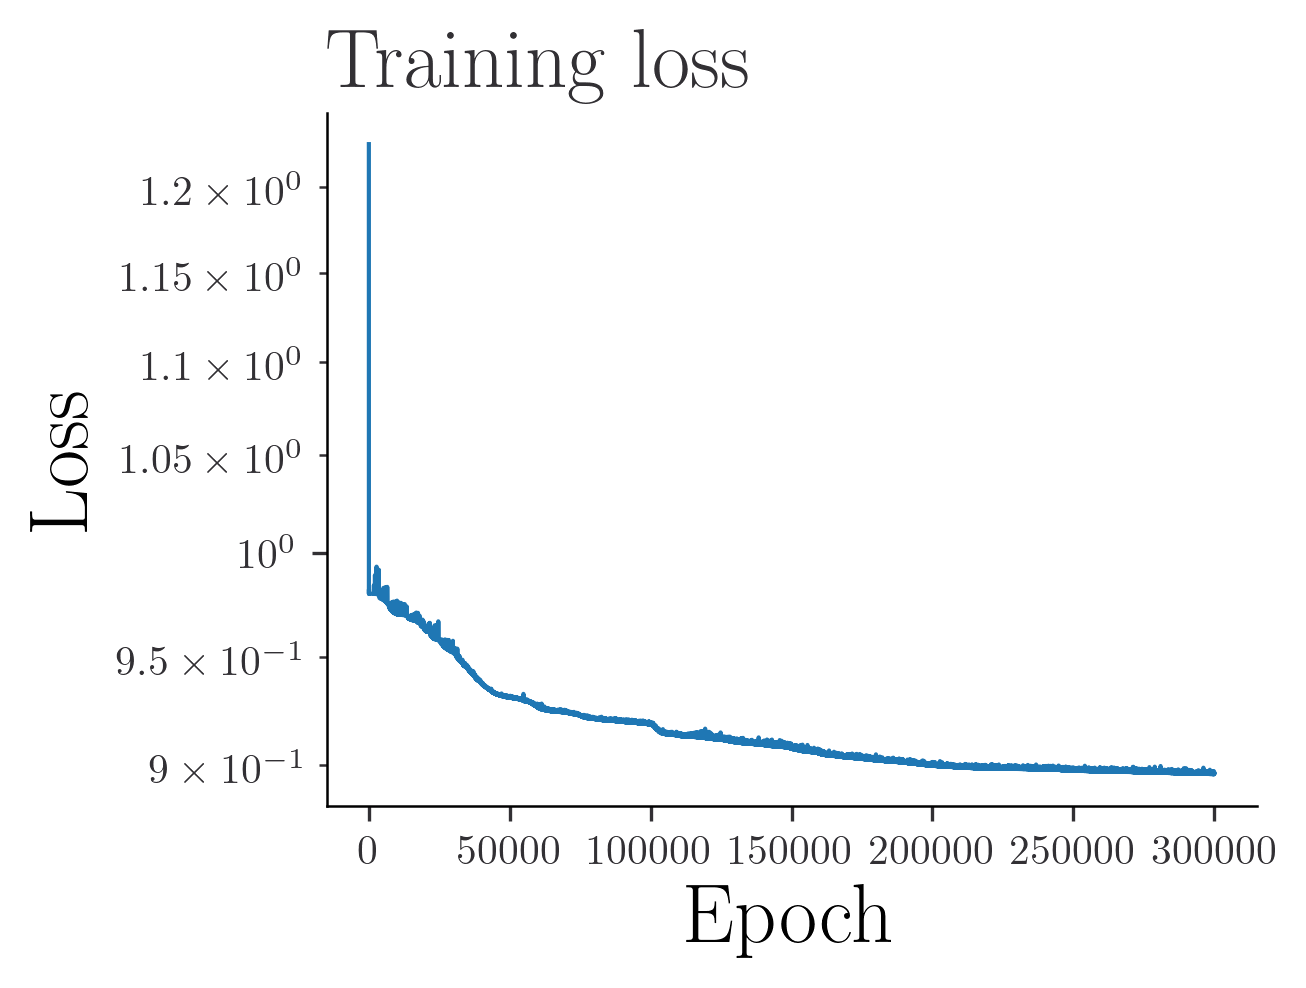

In [18]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

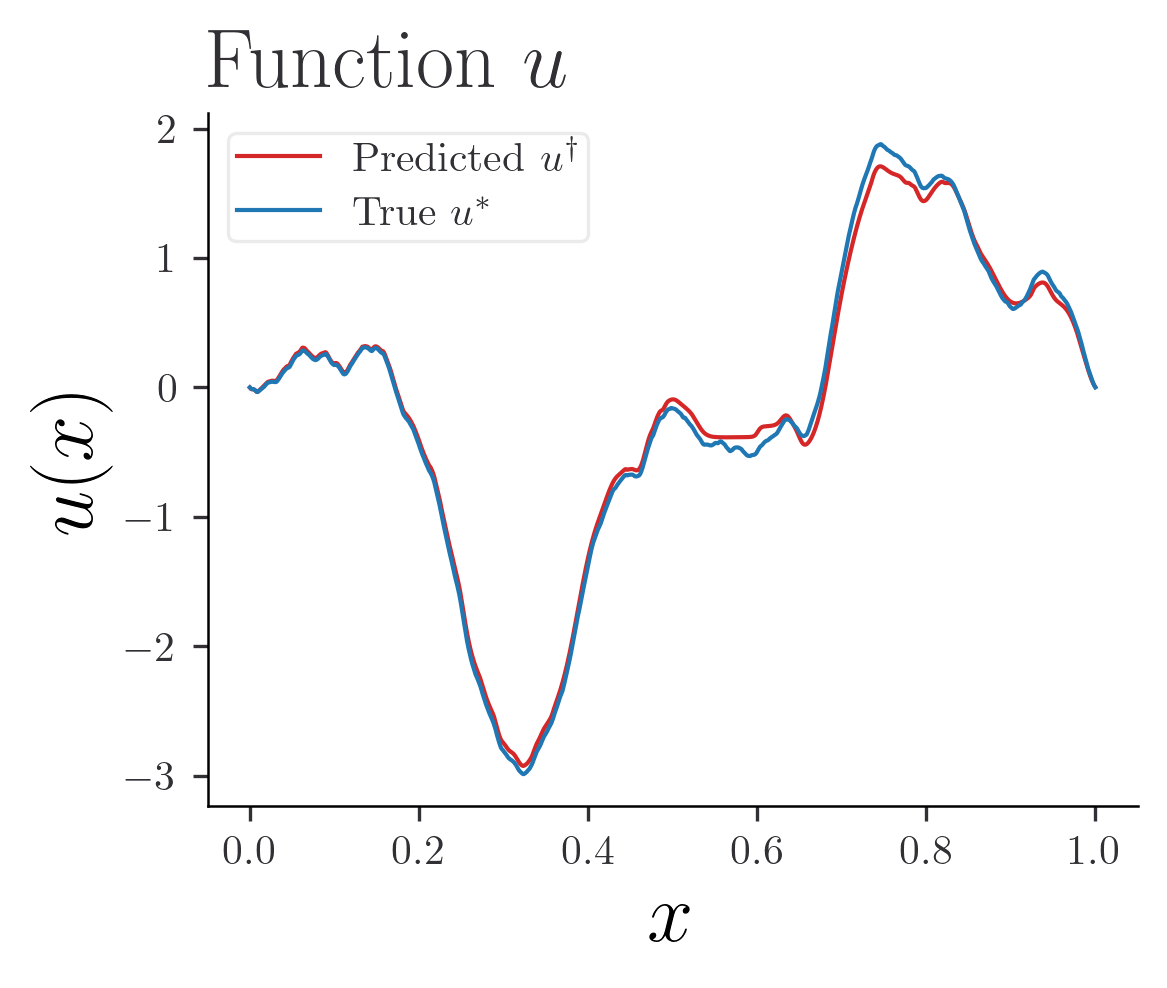

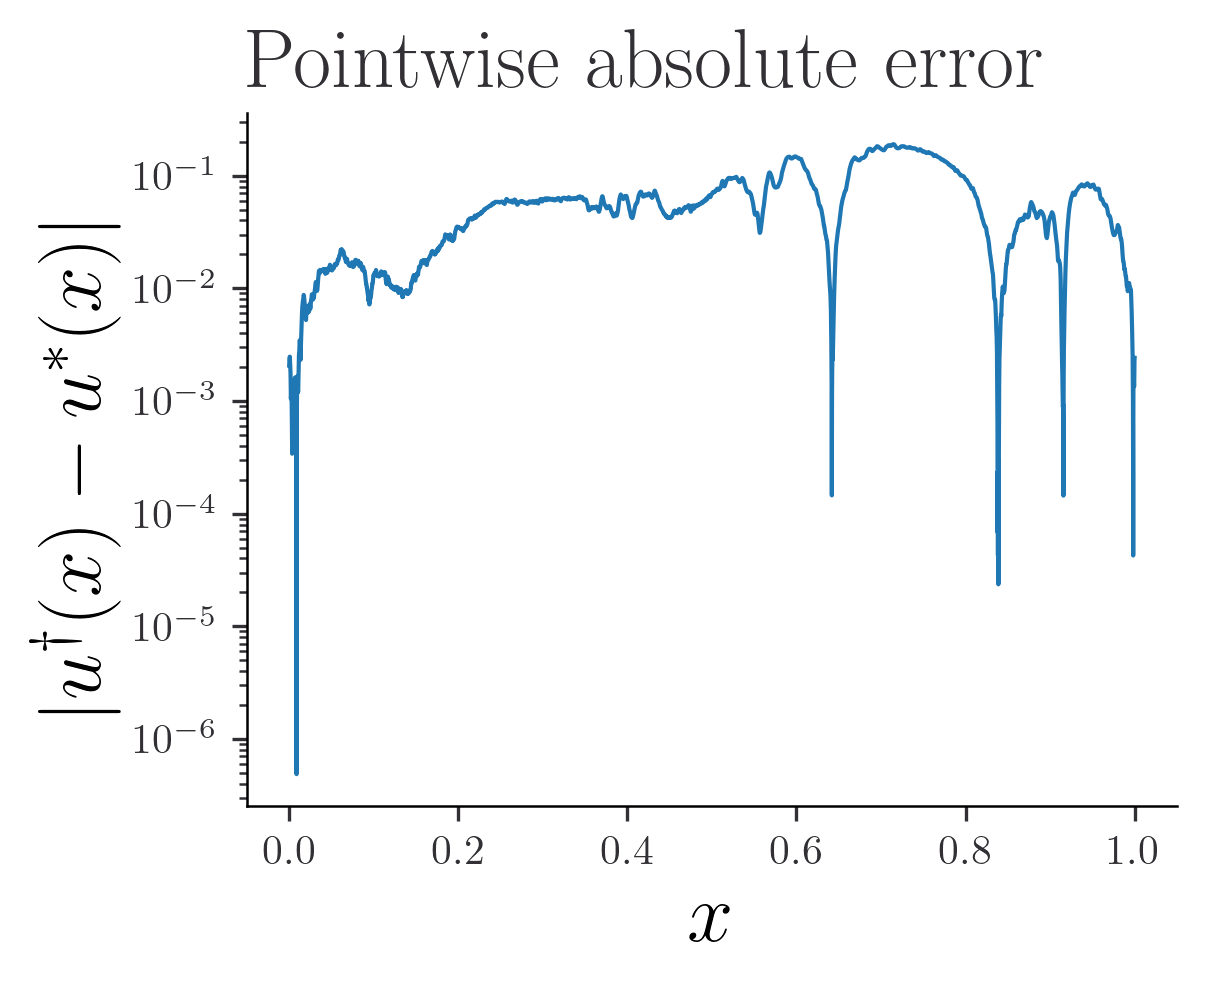

In [19]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


In [20]:
pred_transform = discrete_sine_transform(pred)[1:]
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)


1.9099072616129016 1.534699965988493


In [21]:
jnp.linalg.norm(pred_transform[:n_meas] - coef_u[:n_meas])

Array(1.90990726, dtype=float64)

In [22]:
jnp.sqrt(jnp.mean((pred - u_values)**2))

Array(0.07831397, dtype=float64)

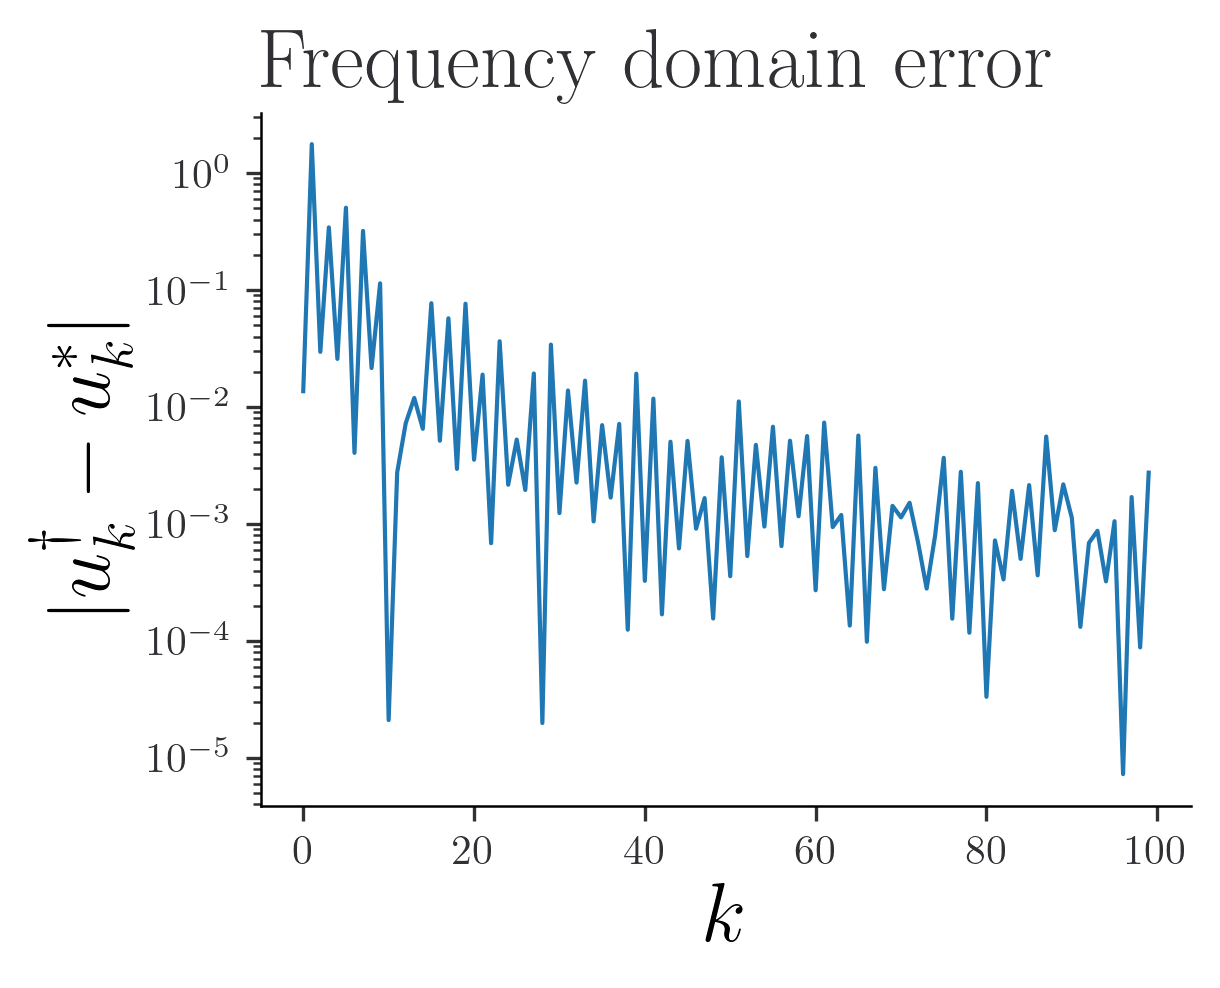

In [23]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

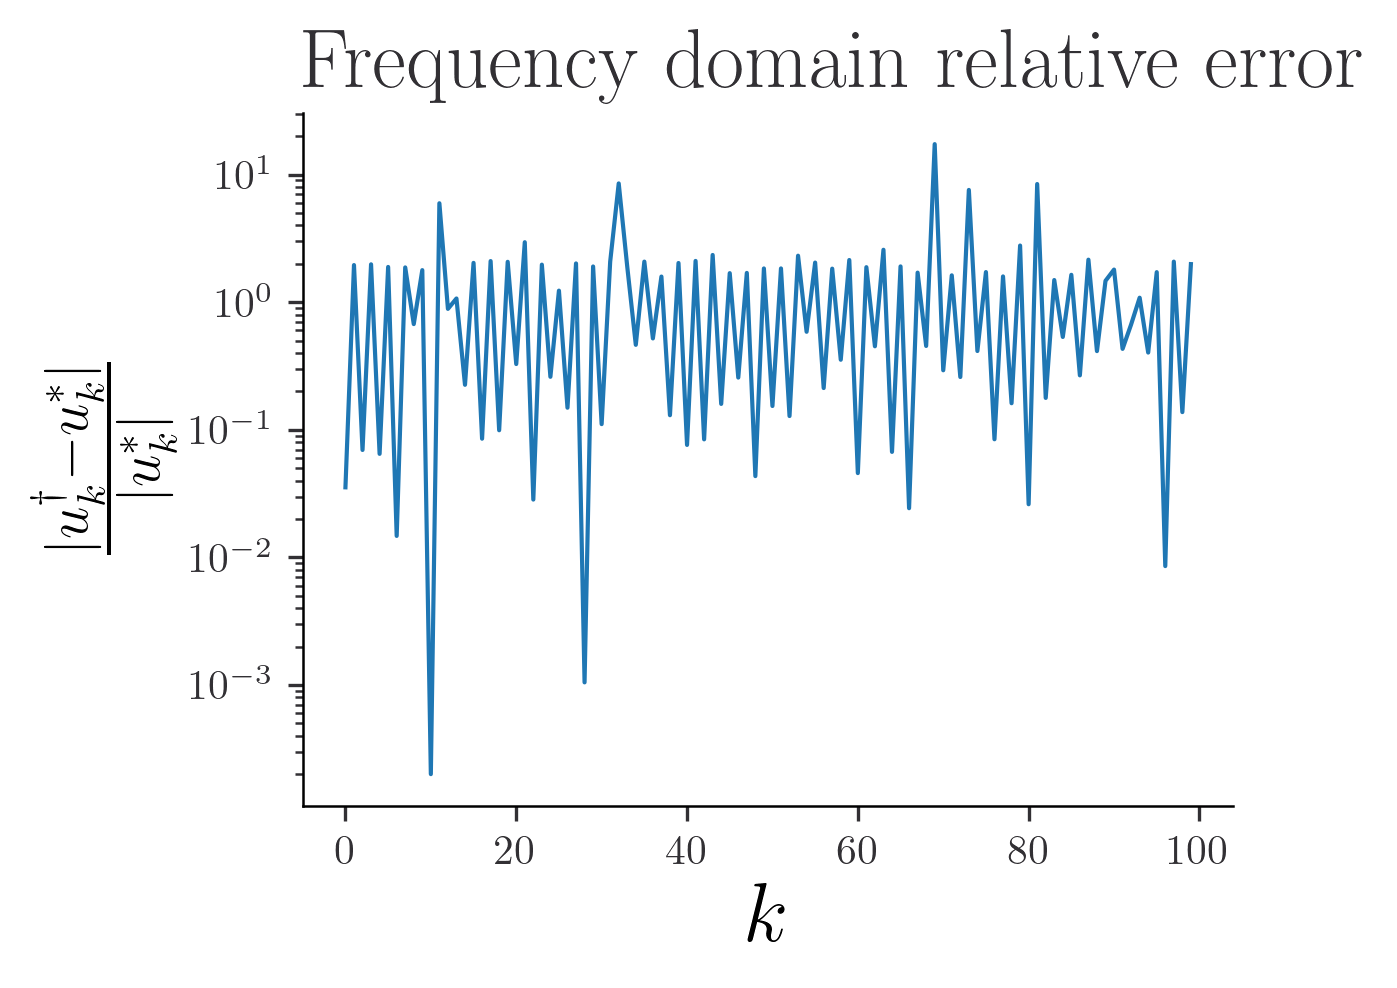

In [24]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# PINN 4096 measurements ($H^{-1/2}$ weighted norm)

In [25]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1)
domain_measurements.shape

nugget = jnp.arange(1, n_meas+1)**(-0.5) # We weight the measurement according to the H^{-0.5} norm
print(nugget)

4096
[1.         0.70710678 0.57735027 ... 0.01562882 0.01562691 0.015625  ]


In [26]:
layer_sizes = [1, 128, 128,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = discrete_sine_transform(-nu*laplacian_grid + u_grid)[1:]
    residual_interior = (pred_sine - f)*nugget

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 16897 parameters in the neural network.


In [27]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, coef_f[:n_meas],boundary_conditions, nu)
print(loss, grads)

() ()
(4097,) (4097,)
0.24771100086417036 [(Array([[ 7.24500179e-02,  1.10386872e-03,  5.60386694e-03,
         4.87535059e-03,  1.76031587e-02, -1.34916290e-03,
        -2.47734560e-02,  1.56821148e-01,  3.48693060e-02,
         3.12076295e-04, -1.35713695e-01,  8.45276579e-02,
        -1.06744912e-02,  7.57317849e-04,  4.09517506e-02,
         1.66335508e-02, -5.21687907e-02,  1.39985998e-01,
        -1.26954958e-01,  1.36620893e-04,  8.44204695e-02,
        -3.72099045e-02,  2.25670171e-02, -1.29228188e-01,
        -6.99186771e-03, -2.27439553e-02, -8.09469781e-03,
        -4.32708055e-02, -9.86678542e-02,  8.27224315e-02,
         6.34120260e-02,  9.19449863e-02, -8.29994498e-03,
        -6.32457376e-03, -3.06343730e-03, -7.44786263e-03,
        -3.92538765e-03, -1.25284733e-03, -2.25582073e-02,
        -1.36043912e-02, -6.70524504e-03,  4.41800785e-03,
         1.64630171e-03, -1.29475164e-02,  8.29688333e-04,
         7.44721359e-03, -1.86620313e-02, -1.28280788e-02,
         1.5

In [28]:
# Define the optimizer
optimizer = optax.adamw(1e-3, weight_decay = 0.0)
opt_state = optimizer.init(params)

In [29]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, coef_f[:n_meas],boundary_conditions, nu)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [30]:
patience = 1000  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [31]:
loss_hist = []
num_epochs = 3e5
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 0.2477110
Epoch 10000, Loss: 0.0016826
Epoch 20000, Loss: 0.0014340
Epoch 30000, Loss: 0.0013415
Epoch 40000, Loss: 0.0011496
Epoch 50000, Loss: 0.0010912
Epoch 60000, Loss: 0.0010221
Epoch 70000, Loss: 0.0009834
Epoch 80000, Loss: 0.0009337
Epoch 90000, Loss: 0.0009243
Epoch 100000, Loss: 0.0009109
Epoch 110000, Loss: 0.0009265
Epoch 120000, Loss: 0.0008572
Epoch 130000, Loss: 0.0008349
Epoch 140000, Loss: 0.0008288
Epoch 150000, Loss: 0.0008210
Epoch 160000, Loss: 0.0008151
Epoch 170000, Loss: 0.0008097
Epoch 180000, Loss: 0.0008075
Early stopping at epoch 188962


In [32]:
pred = neural_network(params, domain_finest)

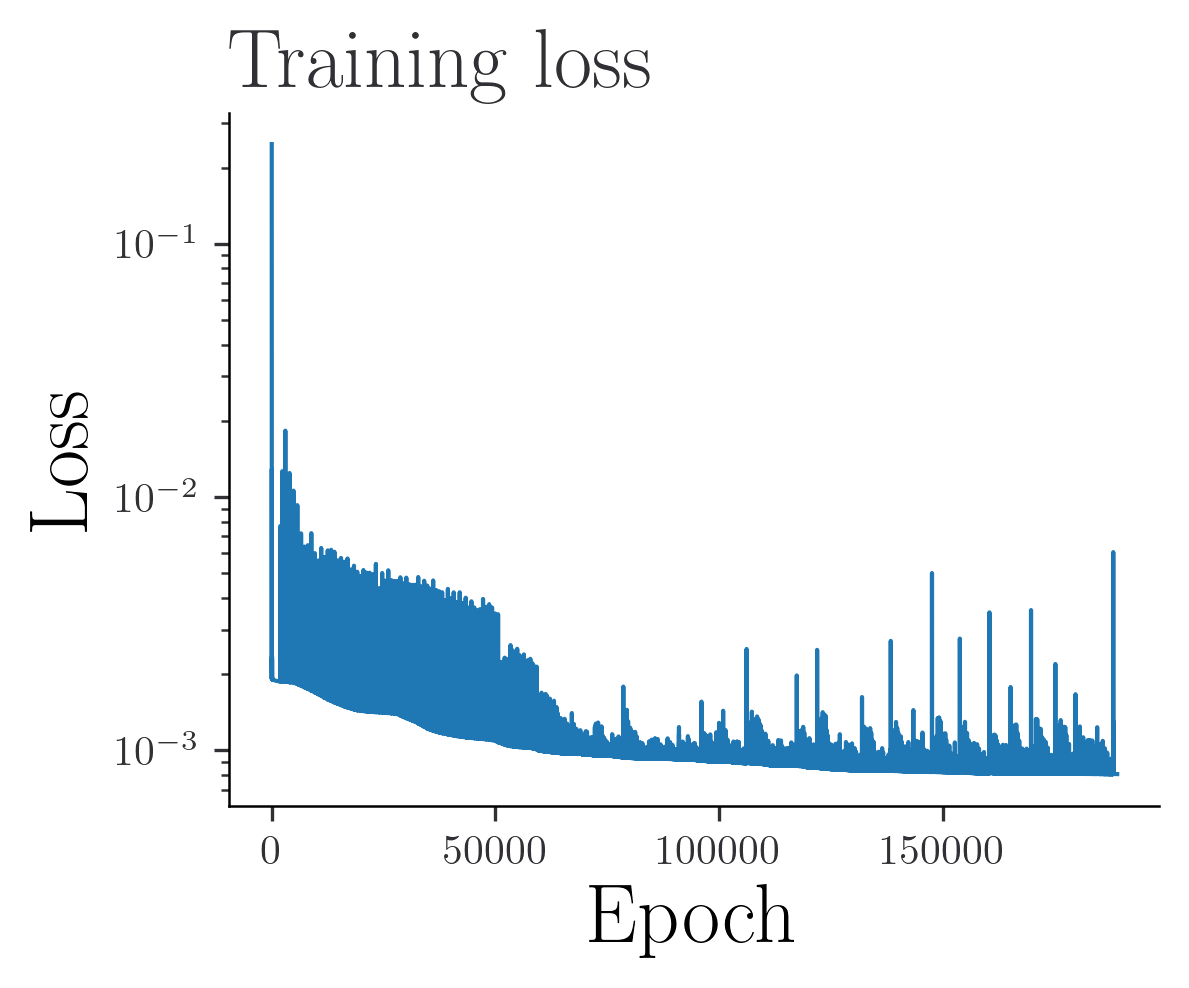

In [33]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

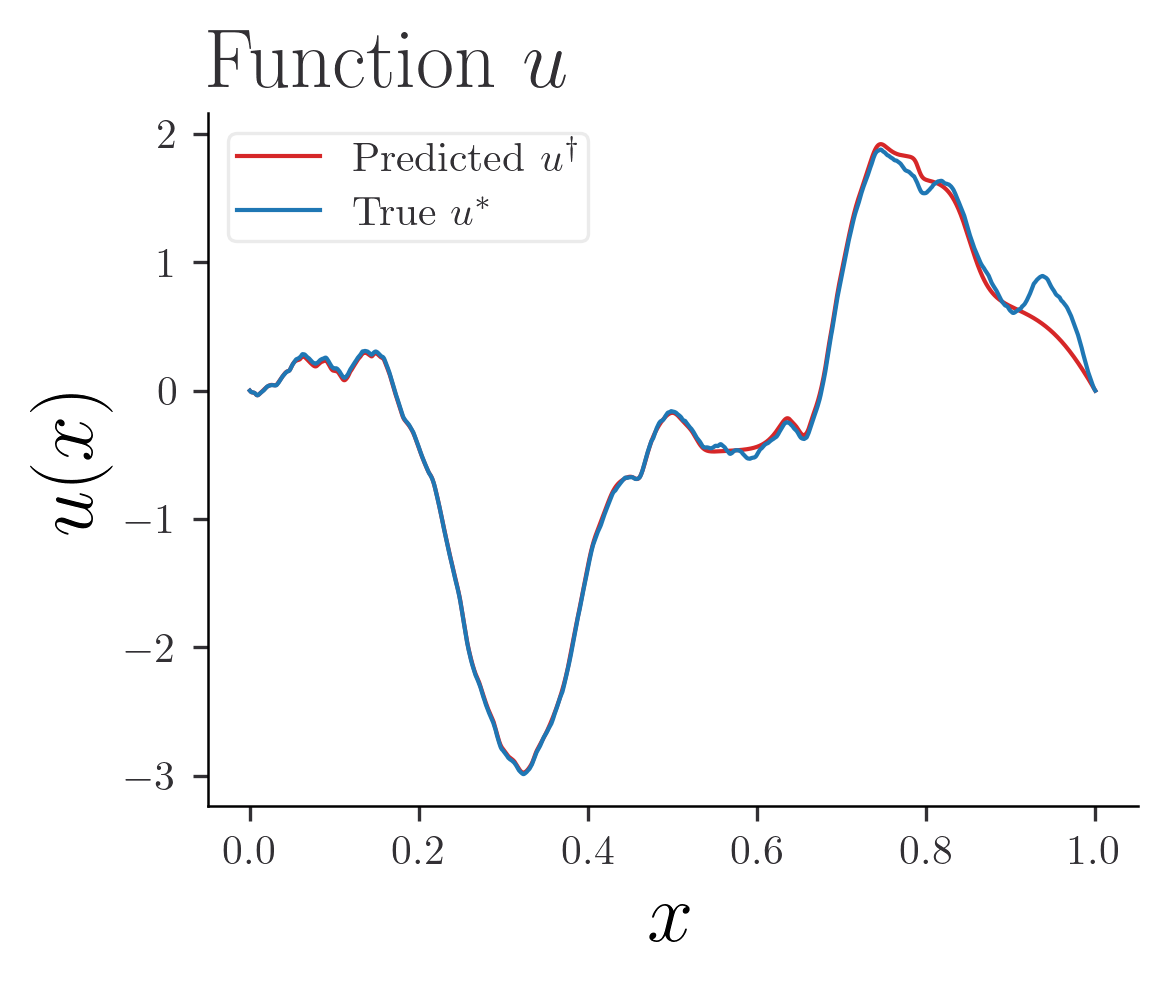

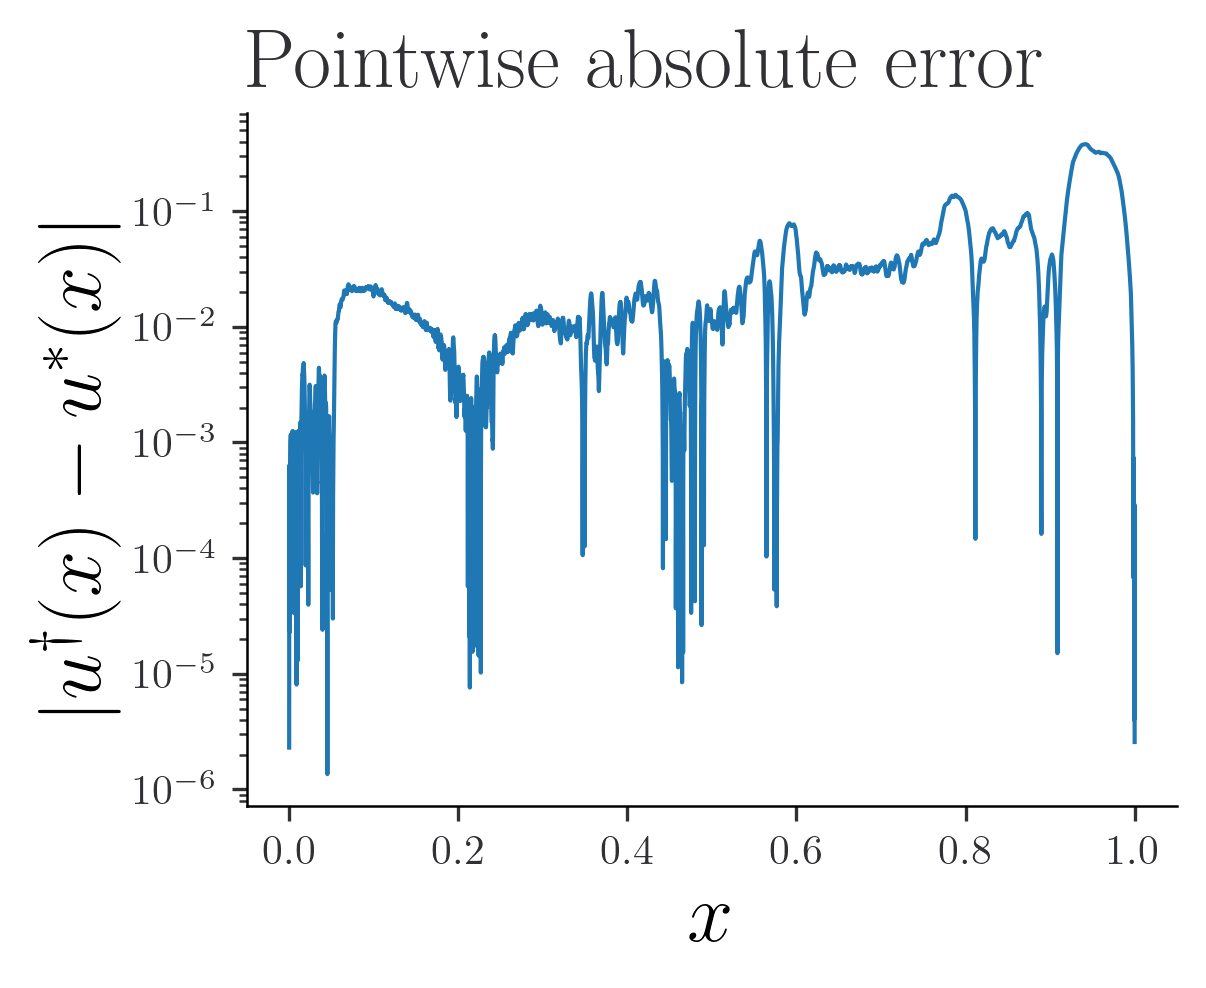

In [34]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


In [35]:
pred_transform = discrete_sine_transform(pred)[1:]
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)


1.969474498896766 1.5825650319374929


In [36]:
domain_finest.shape, pred.shape

((16385,), (16385,))

In [37]:
print(jnp.linalg.norm(pred_transform[:n_meas] - coef_u[:n_meas]))
print(jnp.sqrt(jnp.mean((pred - u_values)**2)))

1.9694744987695902
0.0851442475450204


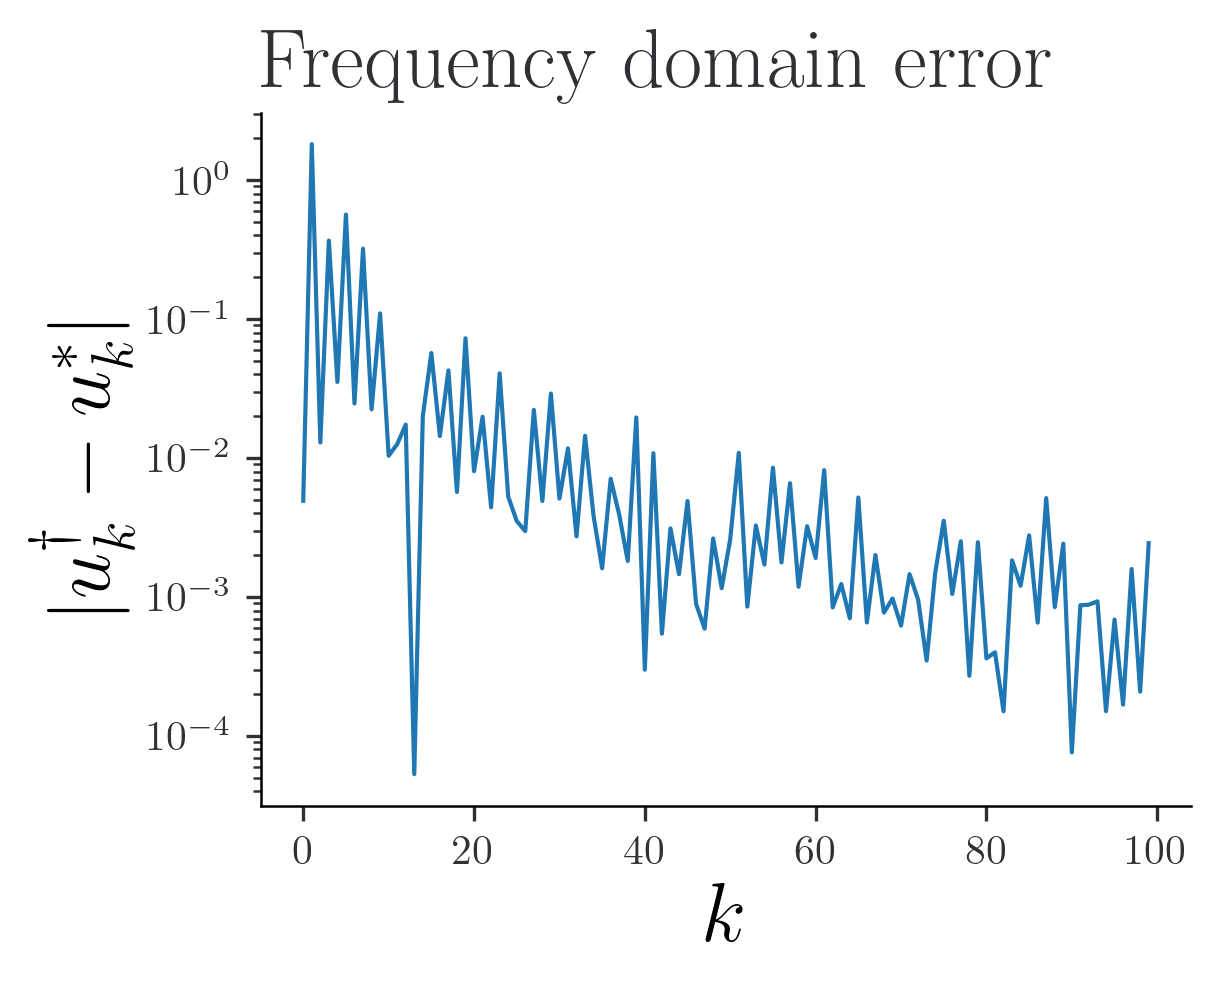

In [38]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

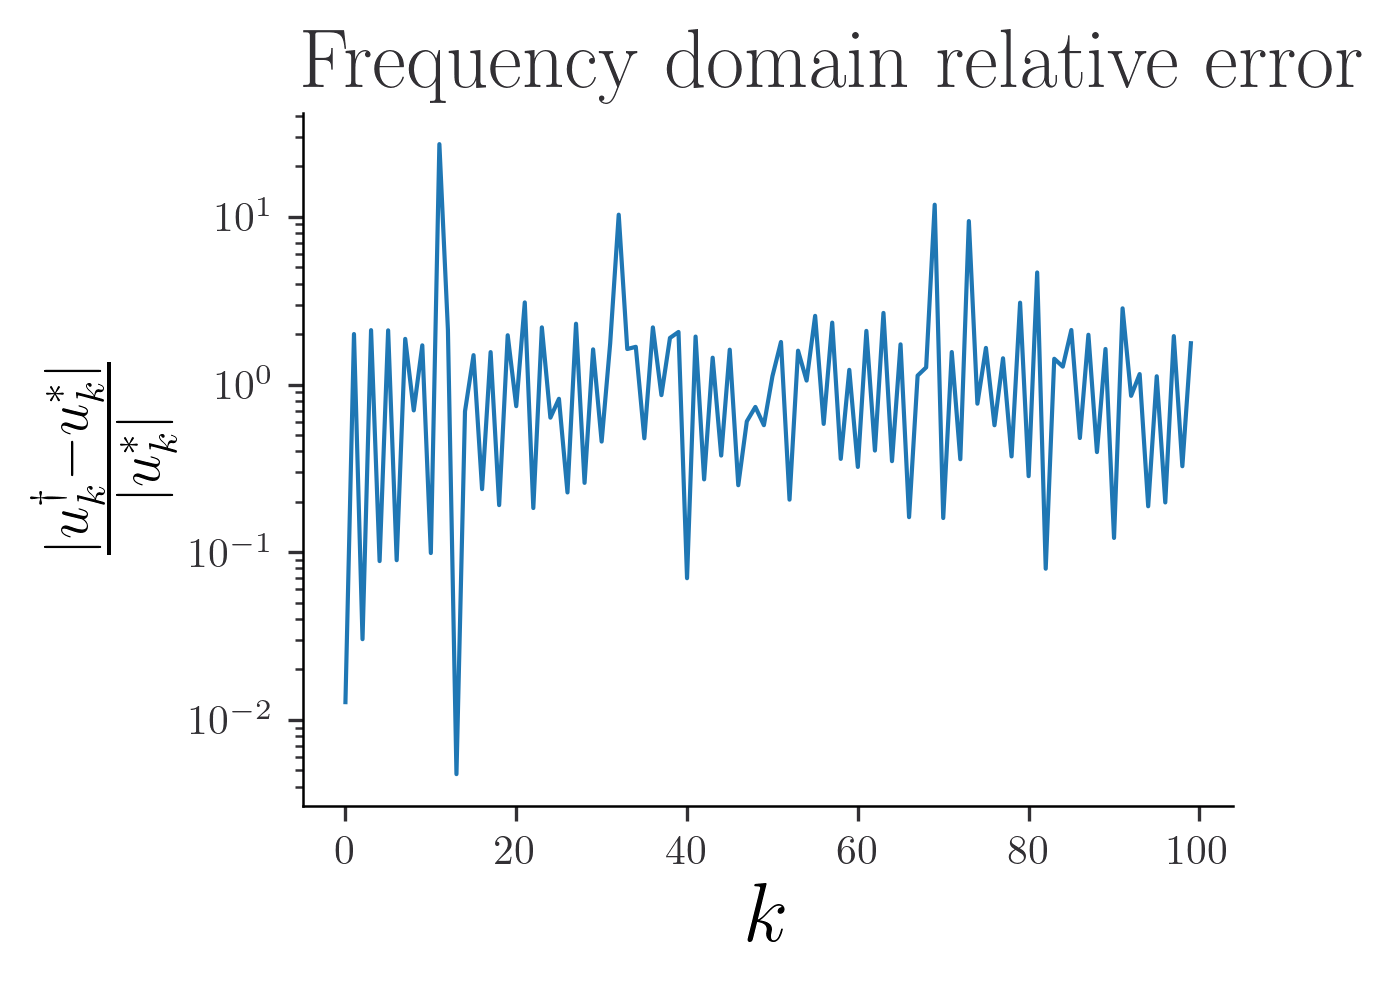

In [39]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# PINN 4096 measurements ($H^{-1}$ weighted norm)

In [40]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1)
domain_measurements.shape

nugget = jnp.arange(1, n_meas+1)**(-1.0) # We weight the measurement according to the H^{-1} norm
print(nugget)

4096
[1.00000000e+00 5.00000000e-01 3.33333333e-01 ... 2.44259893e-04
 2.44200244e-04 2.44140625e-04]


In [41]:
layer_sizes = [1, 128, 128,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = discrete_sine_transform(-nu*laplacian_grid + u_grid)[1:]
    residual_interior = (pred_sine - f)*nugget

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 16897 parameters in the neural network.


In [42]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, coef_f[:n_meas],boundary_conditions, nu)
print(loss, grads)

() ()
(4097,) (4097,)
0.2460117395334894 [(Array([[ 7.24537068e-02,  1.10388916e-03,  5.60358591e-03,
         4.87465046e-03,  1.76042254e-02, -1.34854064e-03,
        -2.47731220e-02,  1.56830294e-01,  3.48705095e-02,
         3.11760973e-04, -1.35720616e-01,  8.45328404e-02,
        -1.06749588e-02,  7.56589702e-04,  4.09539382e-02,
         1.66334132e-02, -5.21719664e-02,  1.39993964e-01,
        -1.26961022e-01,  1.36821506e-04,  8.44256861e-02,
        -3.72118692e-02,  2.25687527e-02, -1.29235178e-01,
        -6.99276485e-03, -2.27447813e-02, -8.09458845e-03,
        -4.32734077e-02, -9.86735115e-02,  8.27262494e-02,
         6.34152577e-02,  9.19504034e-02, -8.29905120e-03,
        -6.32395255e-03, -3.06367756e-03, -7.44781059e-03,
        -3.92596730e-03, -1.25218035e-03, -2.25583332e-02,
        -1.36051185e-02, -6.70542020e-03,  4.41788739e-03,
         1.64719225e-03, -1.29483648e-02,  8.29435302e-04,
         7.44738482e-03, -1.86641743e-02, -1.28288120e-02,
         1.54

In [43]:
# Define the optimizer
optimizer = optax.adamw(1e-3, weight_decay = 0.0)
opt_state = optimizer.init(params)

In [44]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, coef_f[:n_meas],boundary_conditions, nu)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [45]:
patience = 1000  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [46]:
loss_hist = []
num_epochs = 3e5
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.9f}')
    loss_hist.append(loss)

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 0.246011740
Epoch 10000, Loss: 0.000142967
Epoch 20000, Loss: 0.000099456
Epoch 30000, Loss: 0.000071329
Epoch 40000, Loss: 0.000066911
Epoch 50000, Loss: 0.000062775
Epoch 60000, Loss: 0.000055221
Epoch 70000, Loss: 0.000046028
Epoch 80000, Loss: 0.000040967
Epoch 90000, Loss: 0.000031525
Epoch 100000, Loss: 0.000026627
Epoch 110000, Loss: 0.000022747
Early stopping at epoch 115869


In [47]:
pred = neural_network(params, domain_finest)

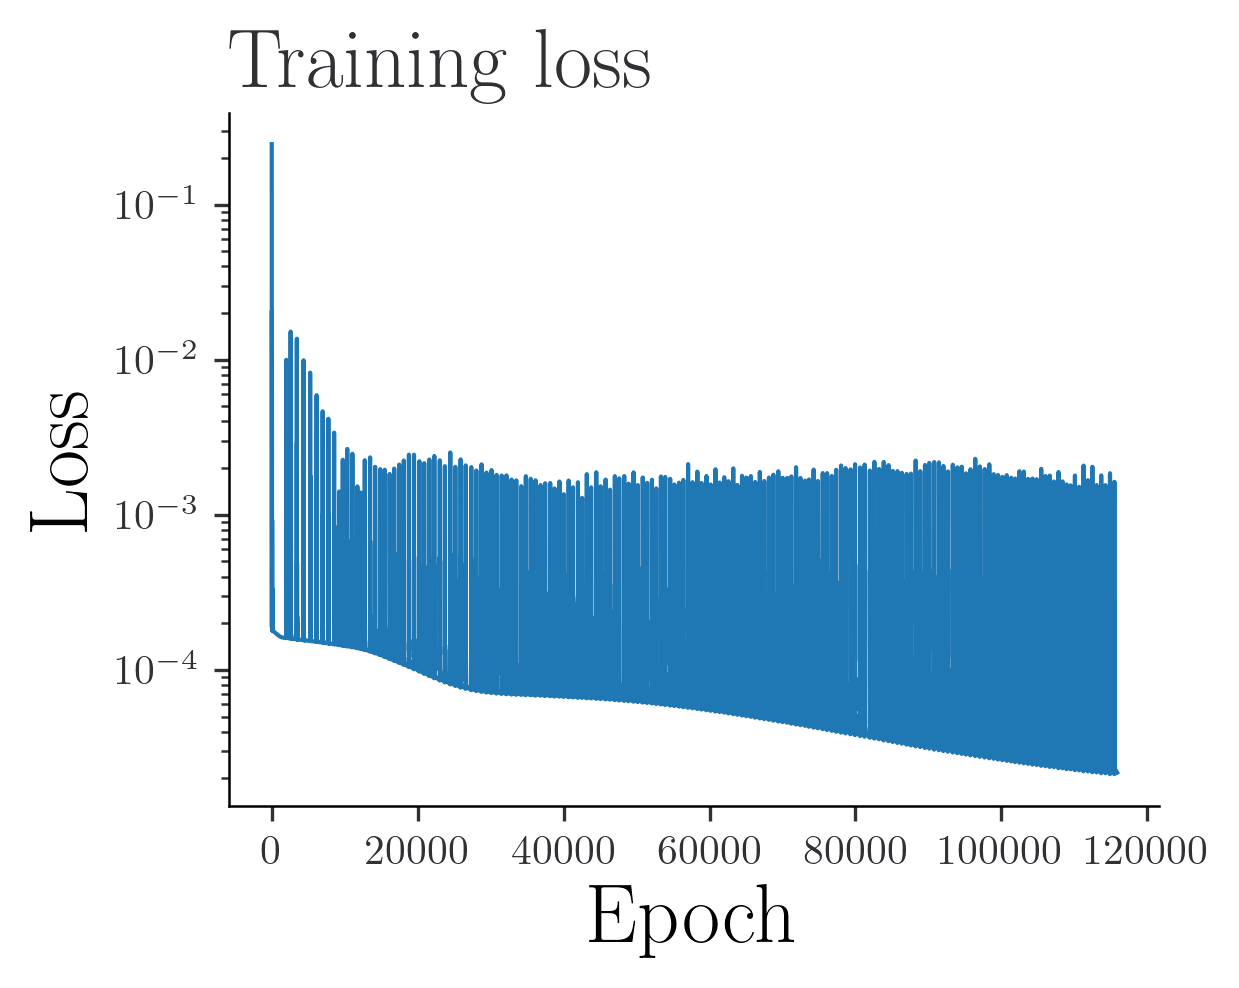

In [48]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

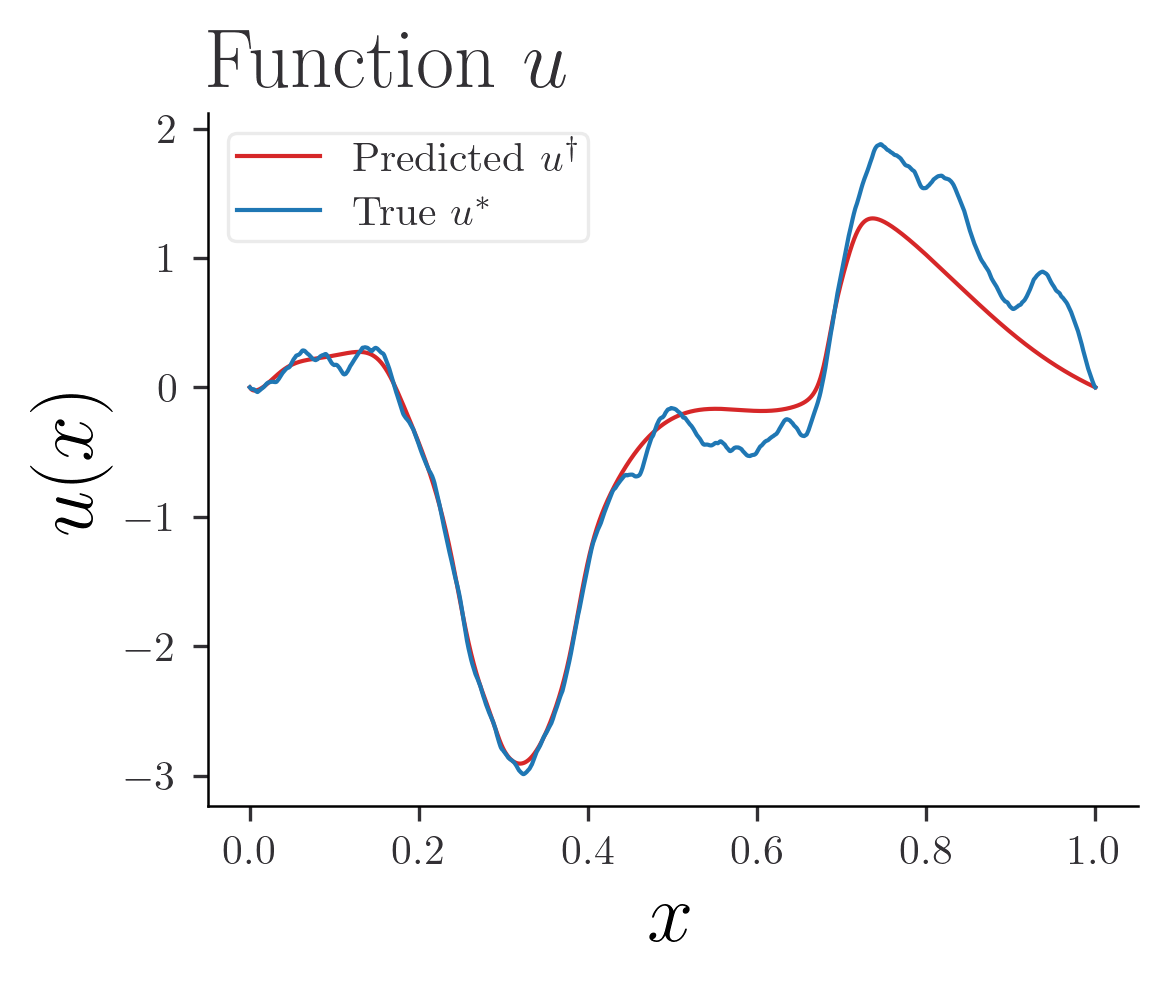

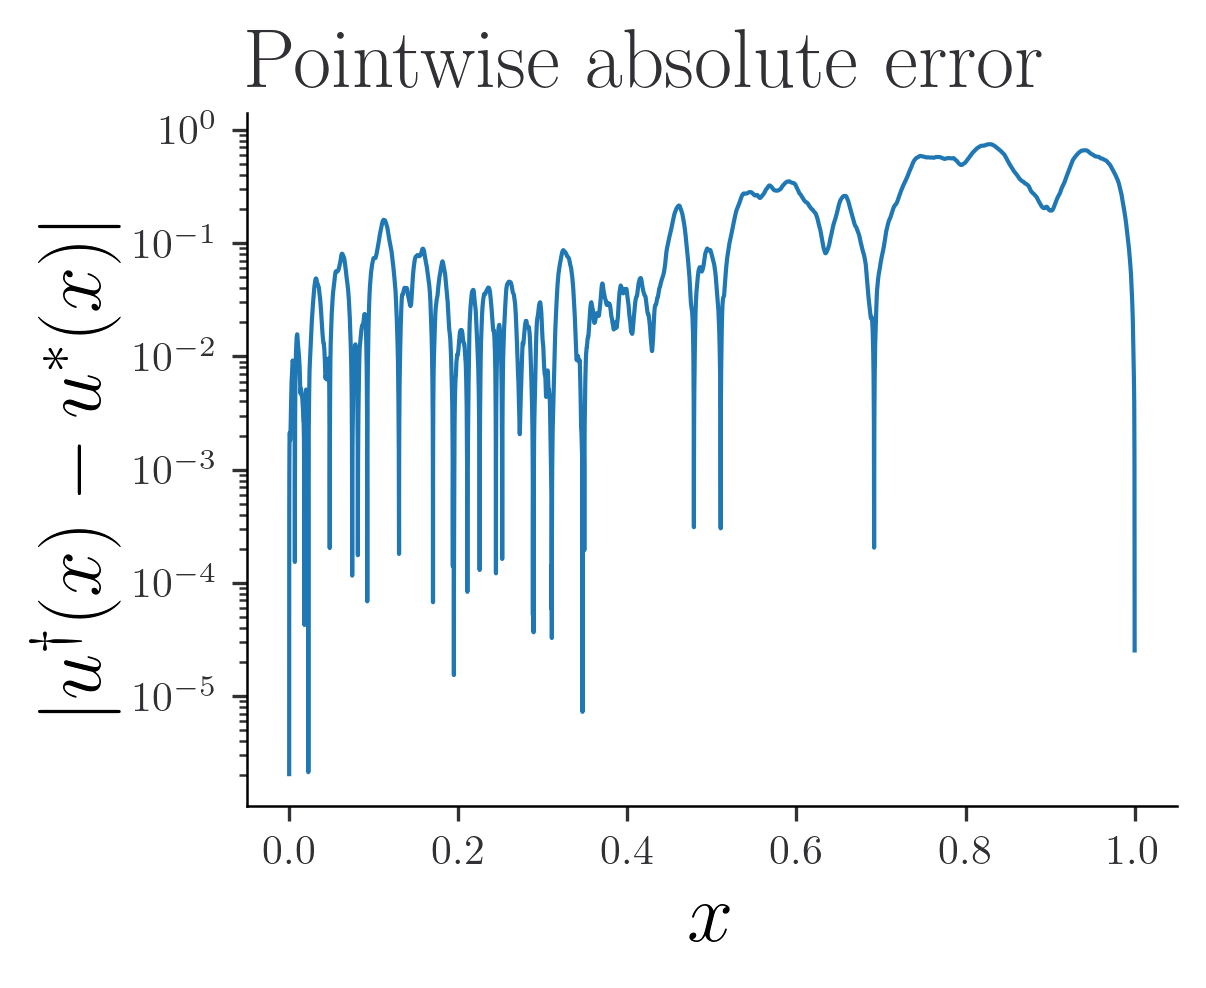

In [49]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


In [50]:
pred_transform = discrete_sine_transform(pred)[1:]
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)


1.8792642985974235 1.510076909548608


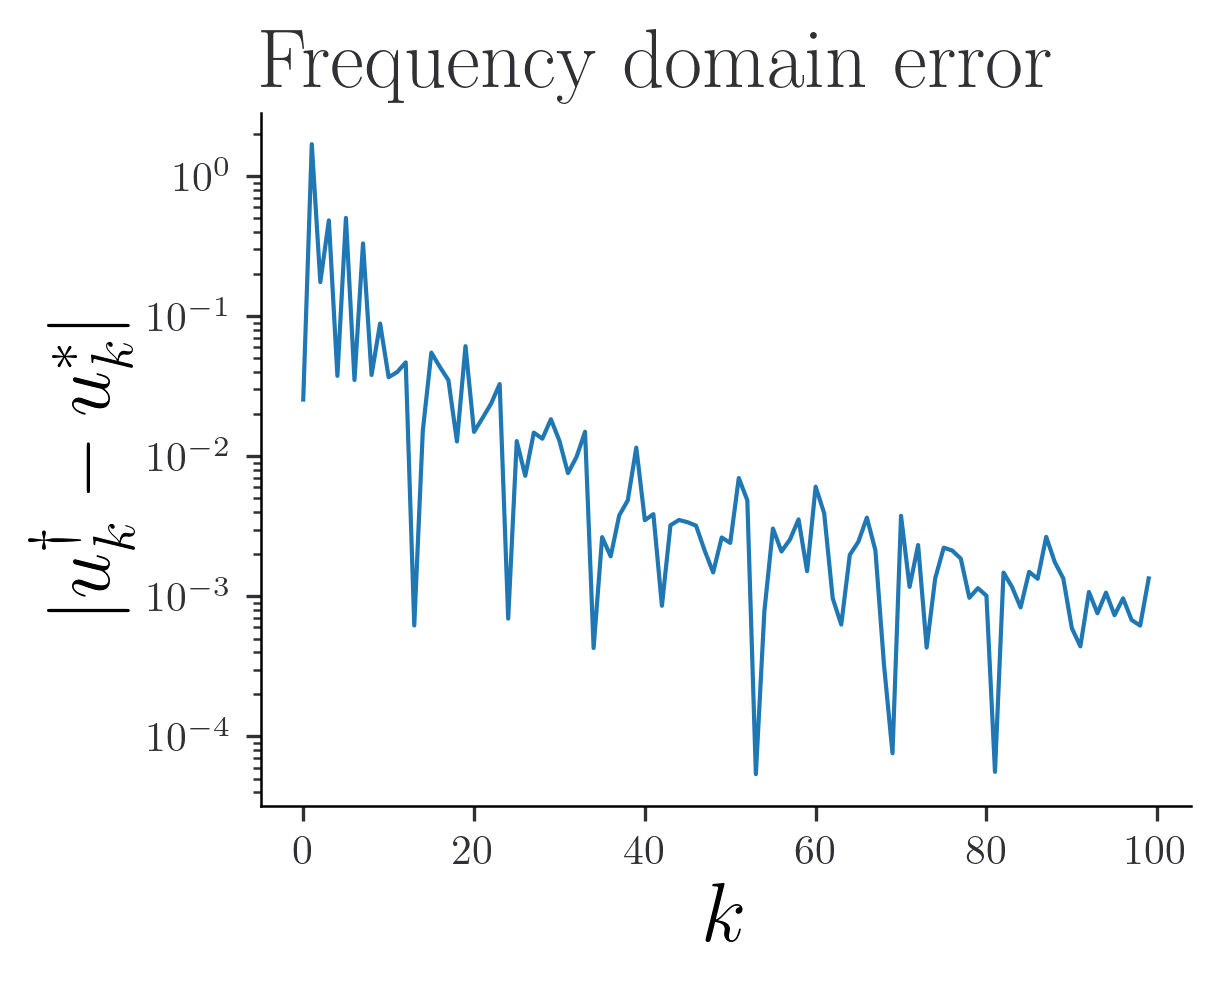

In [51]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

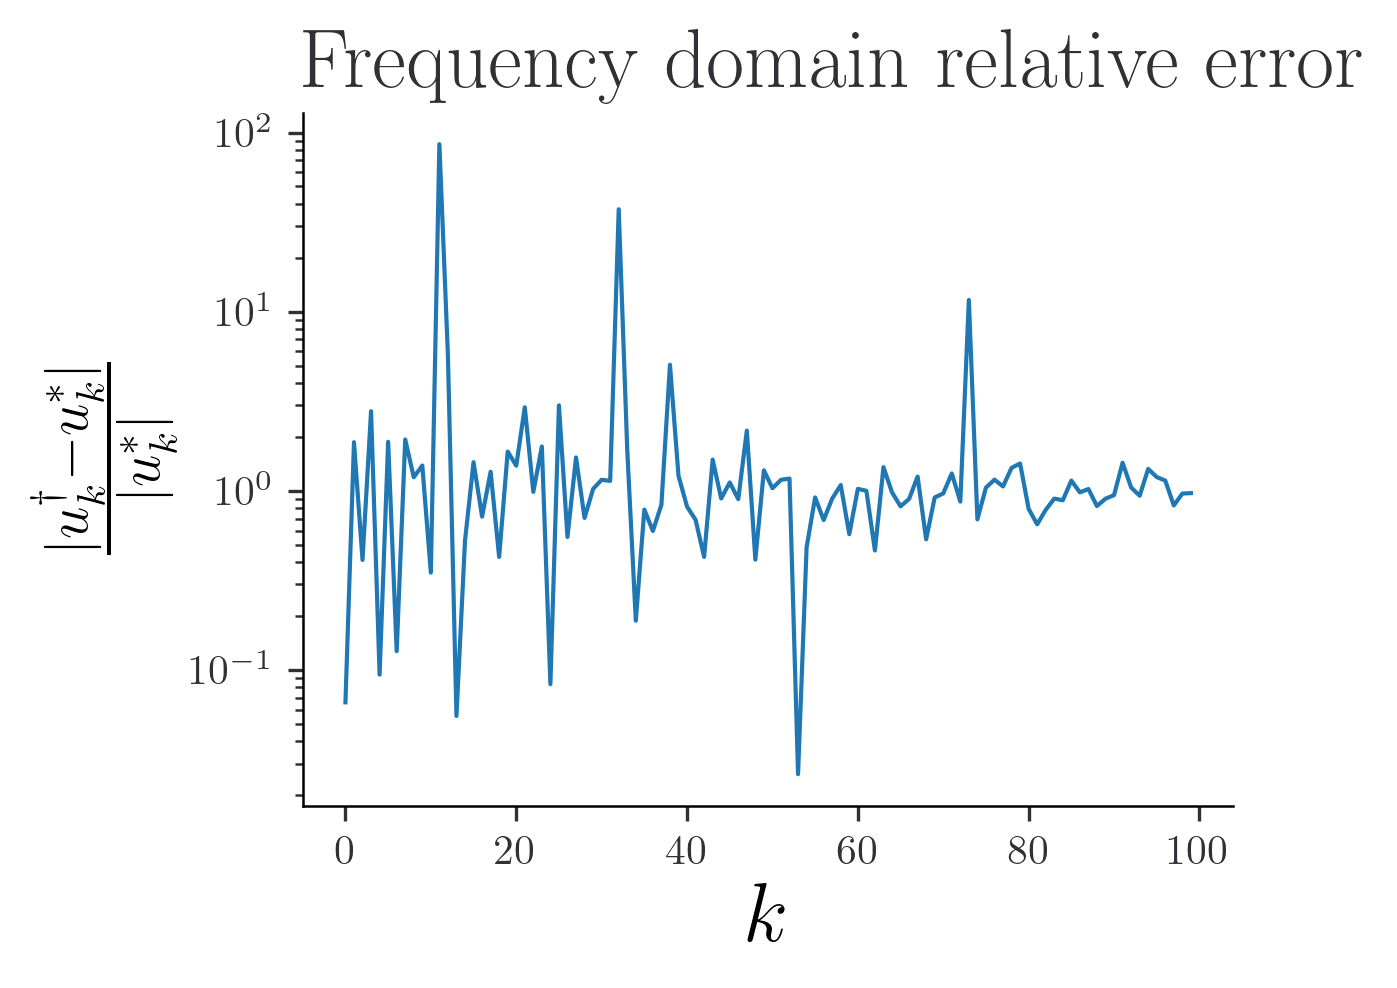

In [52]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# PINN 4096 pointwise measurements

In [53]:
meas_exp = 12
n_meas = 2**meas_exp
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas)

f_pointwise = evaluate_basis_sine(domain_measurements, coef_f)

print(f_pointwise.shape, domain_measurements.shape)

4096
(4096,) (4096,)


In [54]:
layer_sizes = [1, 128, 128,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    residual_interior = -nu*laplacian_grid + u_grid -f #-nu*laplacian_grid + u_grid - f

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 16897 parameters in the neural network.


In [55]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_pointwise,boundary_conditions, nu, 1.0)
print(loss, grads)

() ()
(4096,) (4096,)
16256.74734496861 [(Array([[-3.78038509e-01, -6.77581711e-03, -8.77880479e-02,
        -1.15073012e-01, -1.11387704e-01,  1.28737746e-02,
         2.98698906e-01, -5.62393621e-01, -2.65073482e-01,
        -2.03843991e-02,  5.73734668e-01, -2.53603715e-01,
         7.06945020e-02, -1.12024960e-01, -1.97530238e-01,
        -1.87082947e-01,  2.31386133e-01, -6.22755255e-01,
         5.96449907e-01,  2.04790157e-02, -3.67359636e-01,
         1.24735043e-01, -4.49206230e-02,  4.54184396e-01,
         1.42459915e-02,  1.56243193e-01,  1.02873046e-01,
         2.23969571e-01,  5.43240507e-01, -3.93833444e-01,
        -3.93206731e-01, -3.43710618e-01,  1.98016508e-01,
         1.33036171e-01,  7.97904331e-03,  1.11648712e-01,
         9.70146157e-03,  7.09742425e-02,  2.24371531e-01,
         1.24096618e-01,  5.61444485e-02, -6.54790801e-02,
         2.43075186e-02,  6.70075099e-02, -5.57003357e-02,
        -8.81632778e-02, -1.59461944e-02,  9.17387489e-02,
         2.461

In [56]:
# Define the optimizer
optimizer = optax.adamw(1e-3, weight_decay = 0.0)
opt_state = optimizer.init(params)

In [57]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_pointwise,boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [58]:
patience = 1000  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0
loss_hist = []
num_epochs = 3e5
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 16256.7473450
Epoch 10000, Loss: 15475.2208018
Epoch 20000, Loss: 15277.7086489
Epoch 30000, Loss: 15233.9280445
Epoch 40000, Loss: 15188.6097903
Epoch 50000, Loss: 15110.8359761
Epoch 60000, Loss: 15058.4474935
Epoch 70000, Loss: 15014.0986896
Epoch 80000, Loss: 14943.0695780
Epoch 90000, Loss: 14905.9488076
Epoch 100000, Loss: 14878.2280162
Epoch 110000, Loss: 14827.9409031
Epoch 120000, Loss: 14814.2840384
Epoch 130000, Loss: 14794.3784808
Epoch 140000, Loss: 14779.4567698
Epoch 150000, Loss: 14765.6513279
Epoch 160000, Loss: 14757.7216451
Epoch 170000, Loss: 14738.7875012
Epoch 180000, Loss: 14742.9214113
Epoch 190000, Loss: 14734.2426217
Epoch 200000, Loss: 14726.1446294
Epoch 210000, Loss: 14720.4529767
Epoch 220000, Loss: 14716.9289806
Epoch 230000, Loss: 14703.7133959
Epoch 240000, Loss: 14700.7937071
Epoch 250000, Loss: 14693.7639272
Epoch 260000, Loss: 14690.6030646
Epoch 270000, Loss: 14689.3001164
Epoch 280000, Loss: 14686.2359181
Early stopping at epoch 2812

In [59]:
pred = neural_network(params, domain_finest)

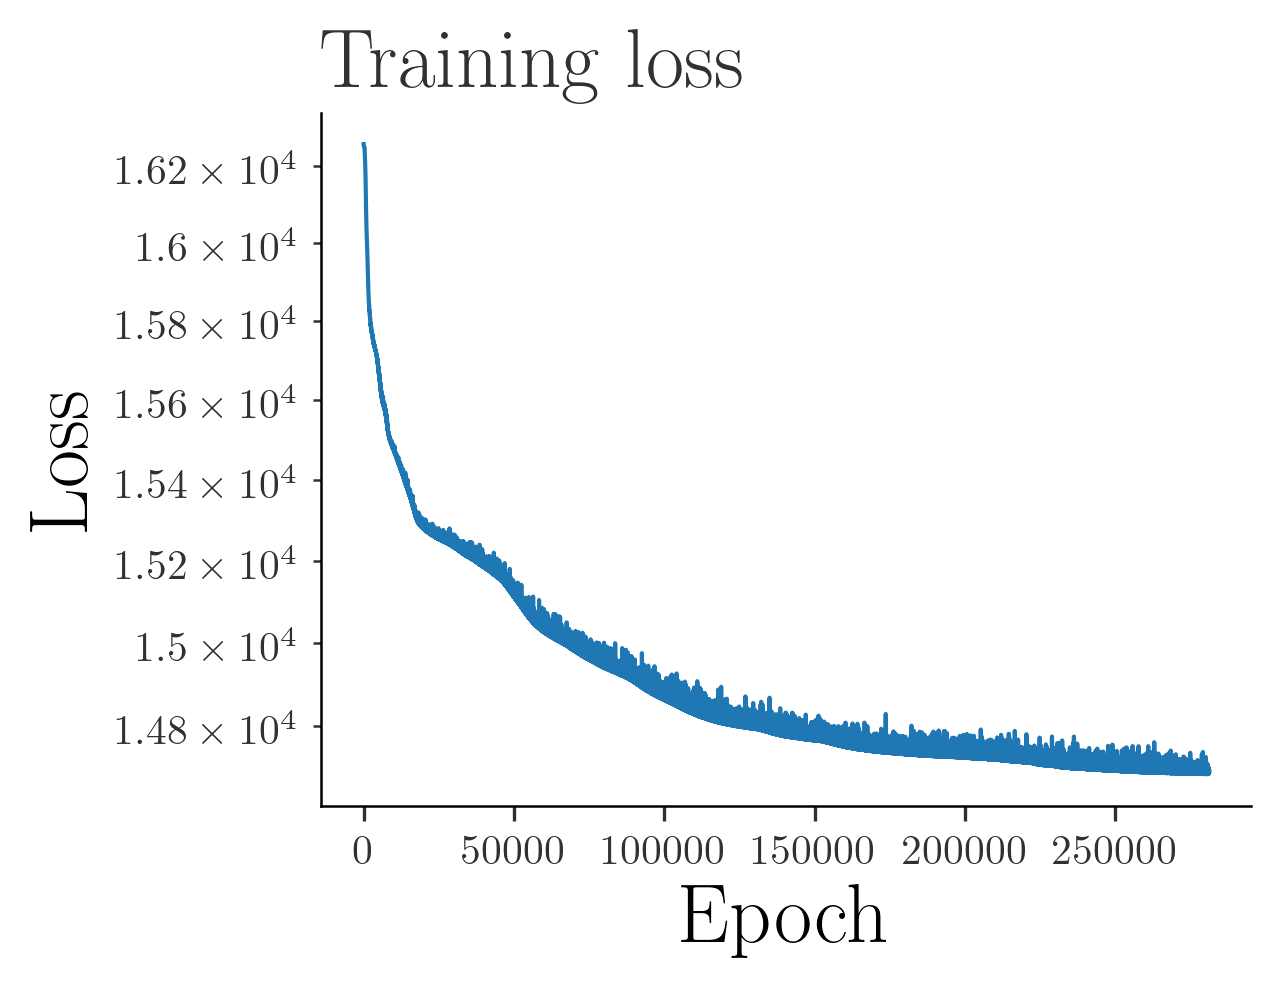

In [60]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

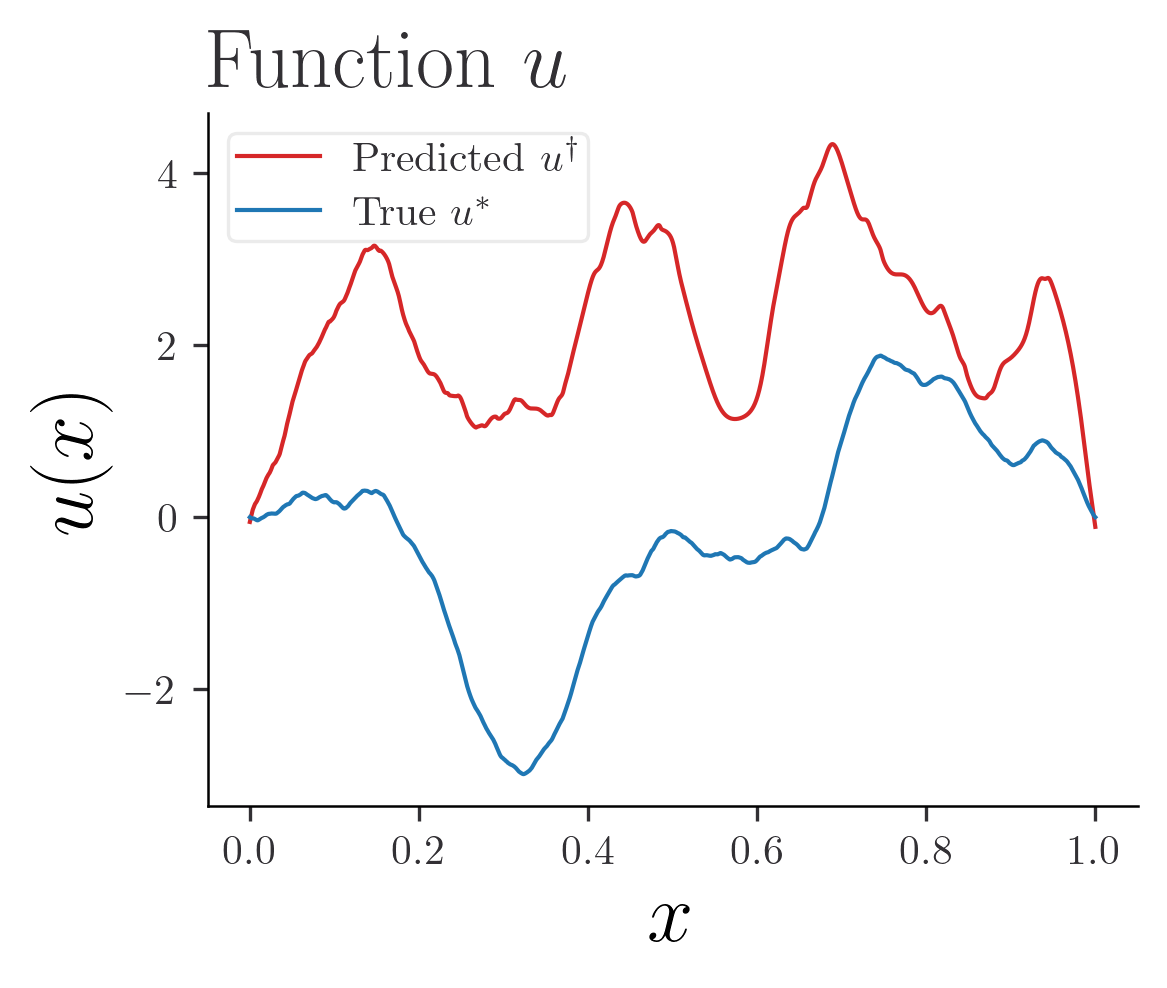

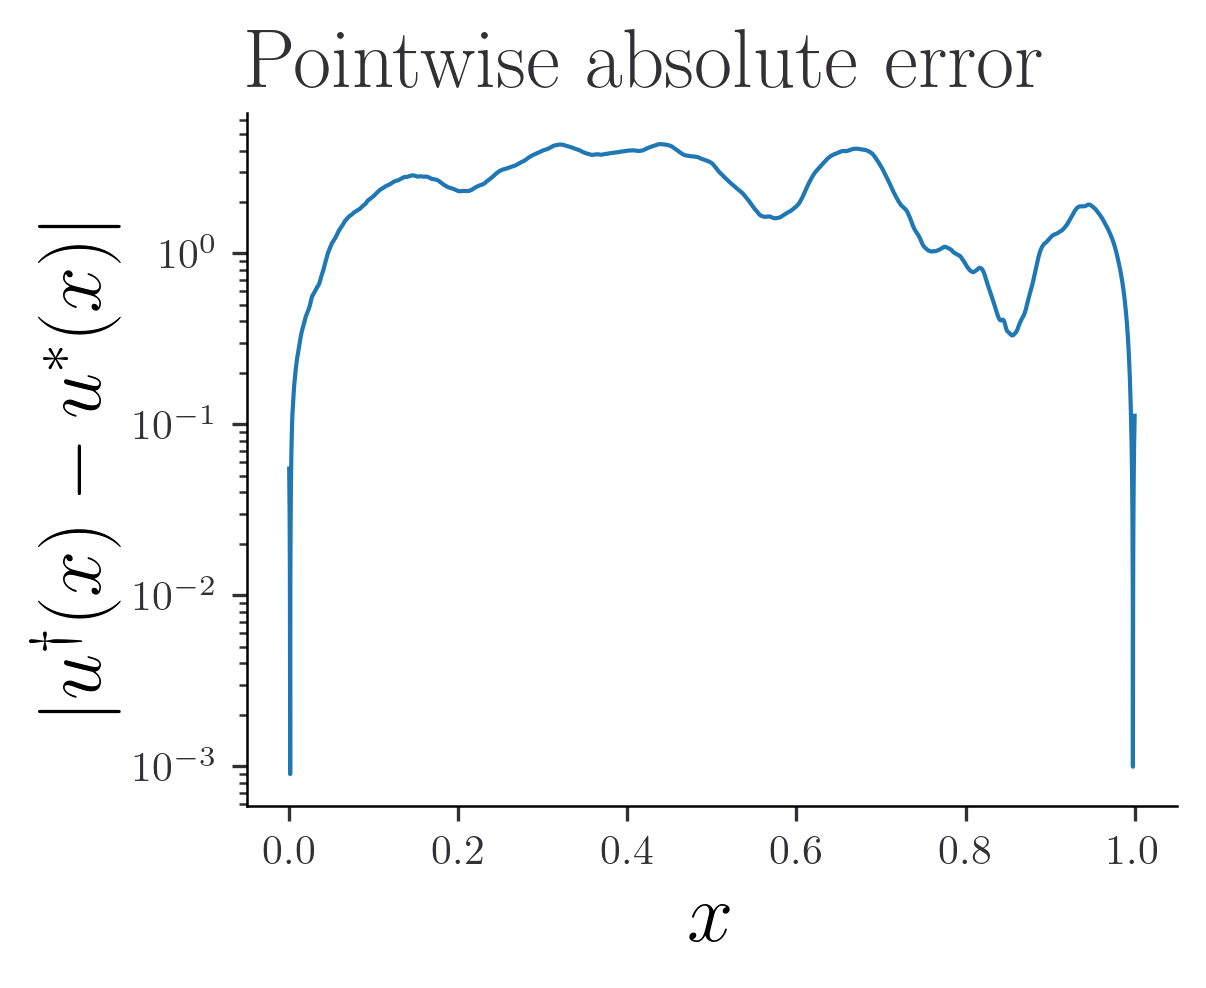

In [61]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


In [62]:
pred_transform = discrete_sine_transform(pred)[1:]
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)


3.0552495051323345 2.4550361192161874


In [63]:
print(jnp.linalg.norm(pred_transform[:n_meas] - coef_u[:n_meas]))
print(jnp.sqrt(jnp.mean((pred - u_values)**2)))

3.0552494447733776
2.6844657526069637


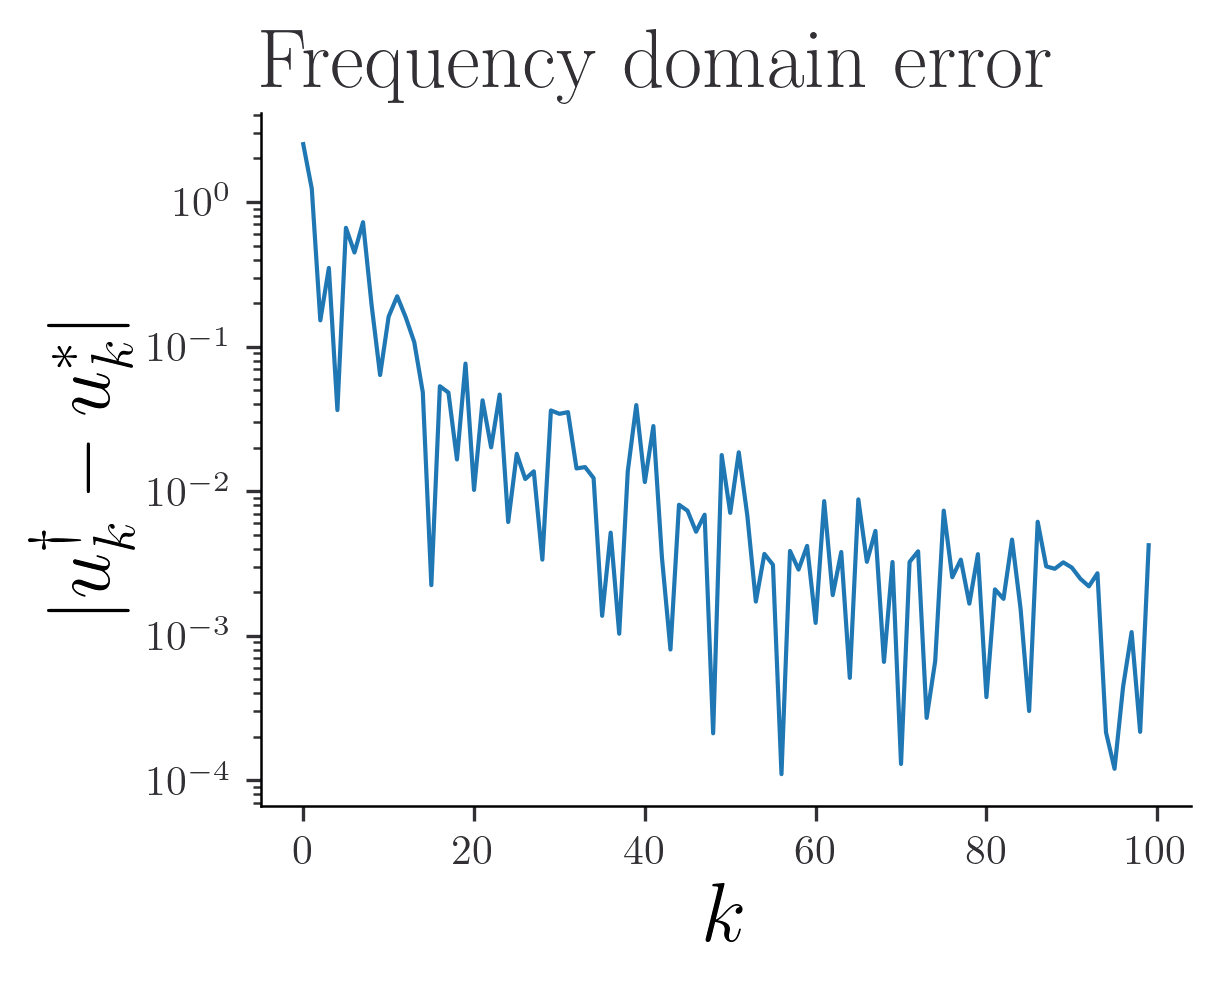

In [64]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

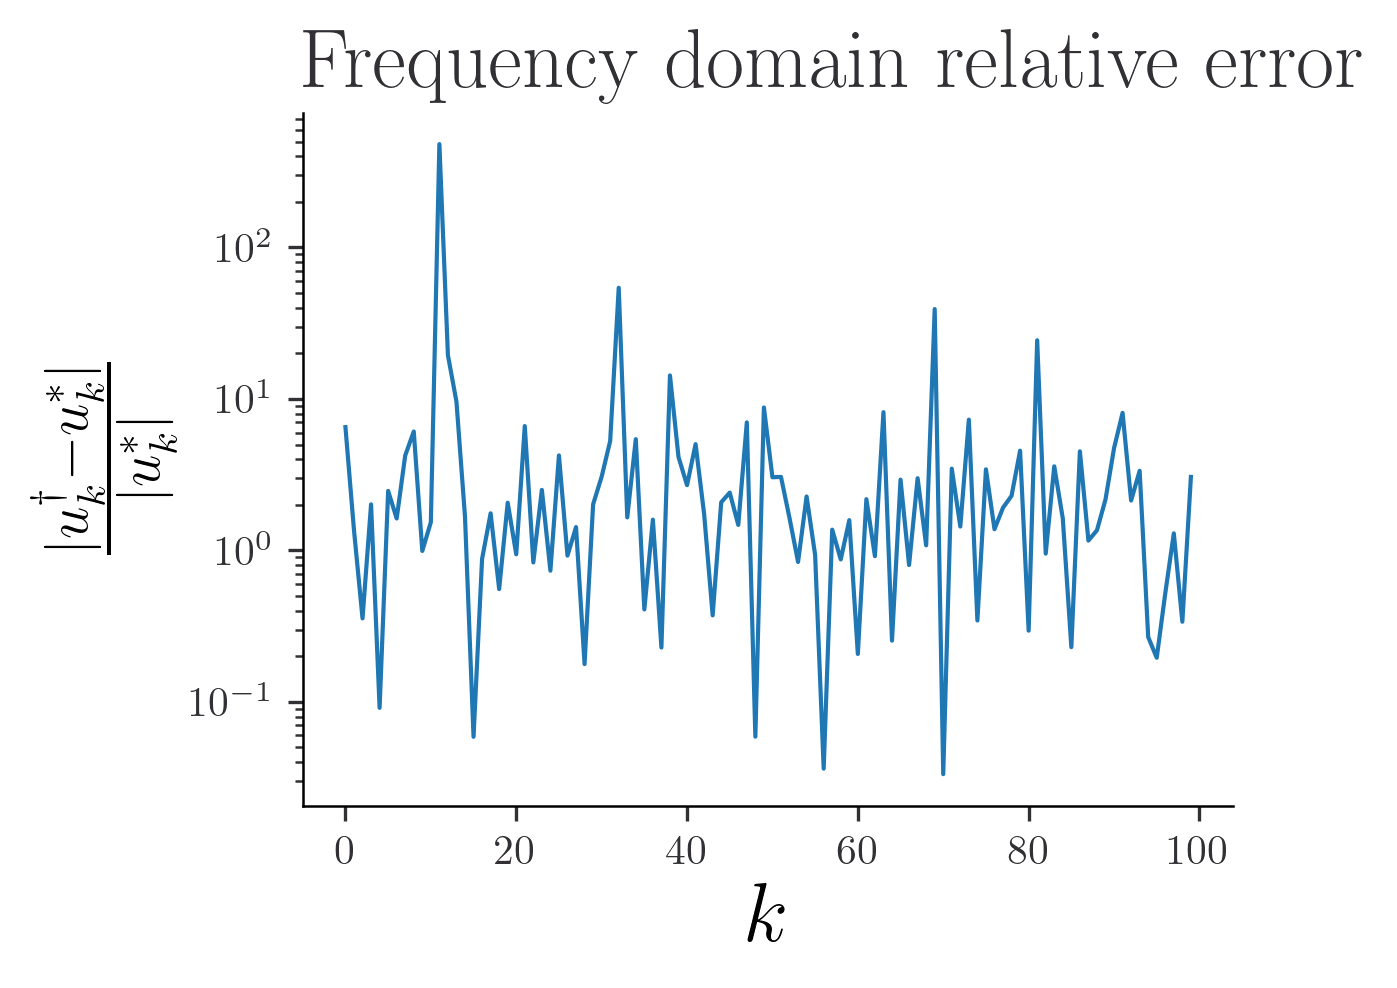

In [65]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

In [ ]:
pred_transform = discrete_sine_transform(pred)[1:]
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)


1.9099072616129016 1.534699965988493


In [ ]:
jnp.linalg.norm(pred_transform[:n_meas] - coef_u[:n_meas])

Array(1.90990726, dtype=float64)

In [ ]:
jnp.sqrt(jnp.mean((pred - u_values)**2))

Array(0.07831397, dtype=float64)

# PINN 1024 measurements

In [ ]:
n_meas = 2**6
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1)
domain_measurements.shape

64


(65,)

In [ ]:
layer_sizes = [1, 512, 512, 512, 512, 1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)

neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = discrete_sine_transform(-nu*laplacian_grid + u_grid)[1:]
    residual_interior = pred_sine - f

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

In [ ]:
# Define the optimizer
optimizer = optax.adamw(1e-3, weight_decay = 1e-6)
opt_state = optimizer.init(params)

In [ ]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, coef_f[:n_meas],boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [ ]:
loss_hist = []
num_epochs = 2e4
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')
    loss_hist.append(loss)

Epoch 0, Loss: 0.9457
Epoch 10000, Loss: 0.2186


In [ ]:
pred = neural_network(params, domain_finest)

Text(0.0, 1.0, 'Training loss')

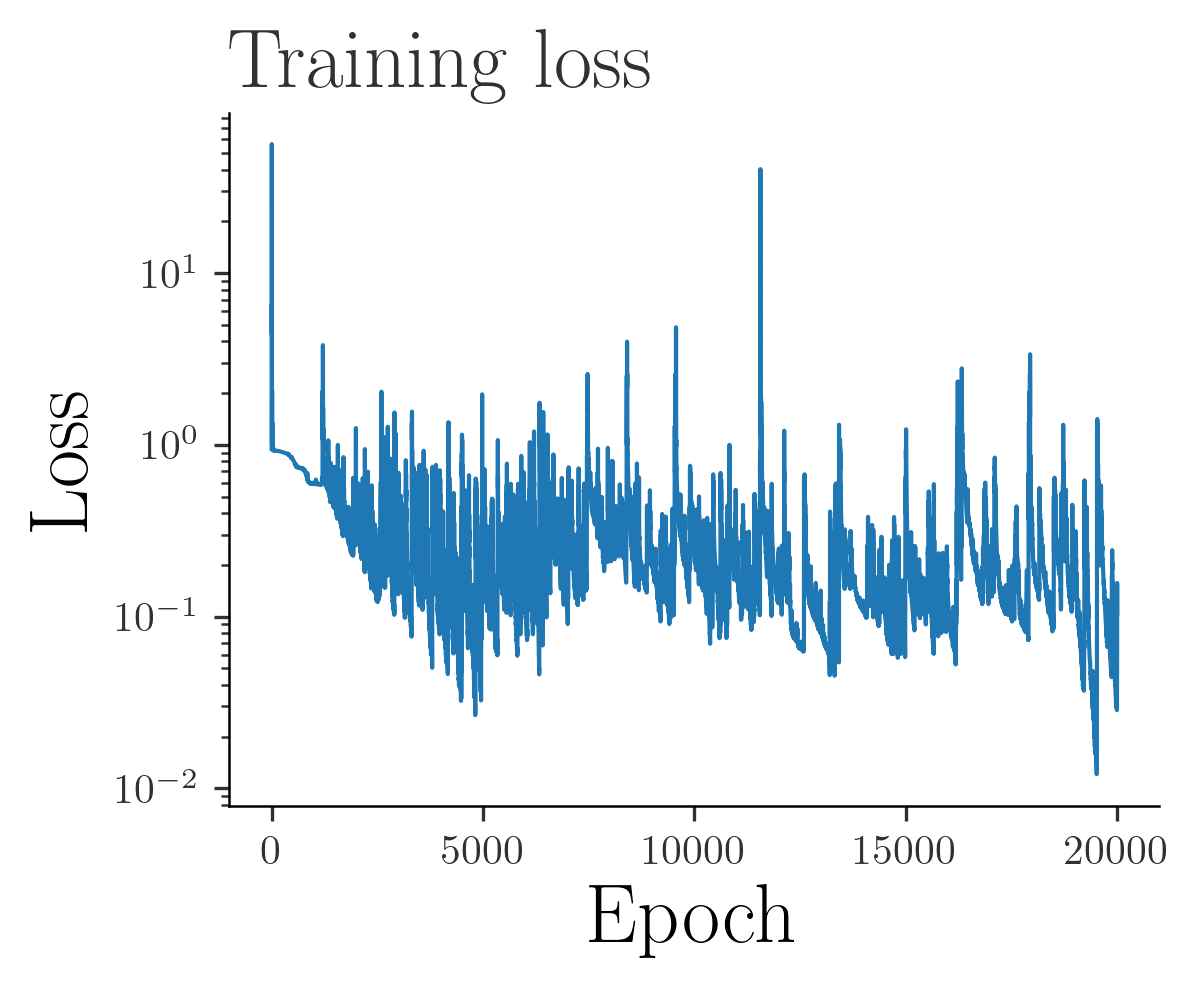

In [ ]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')

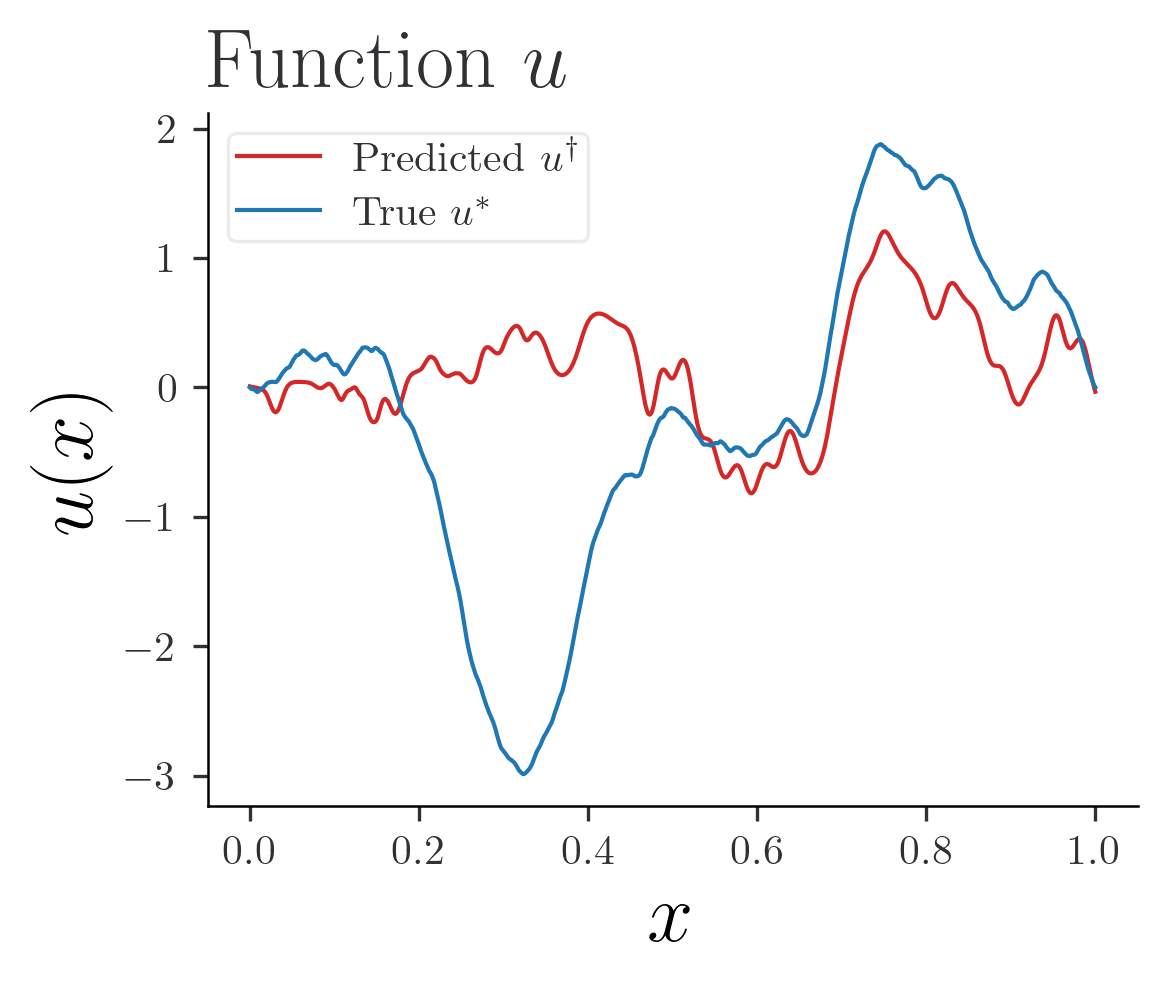

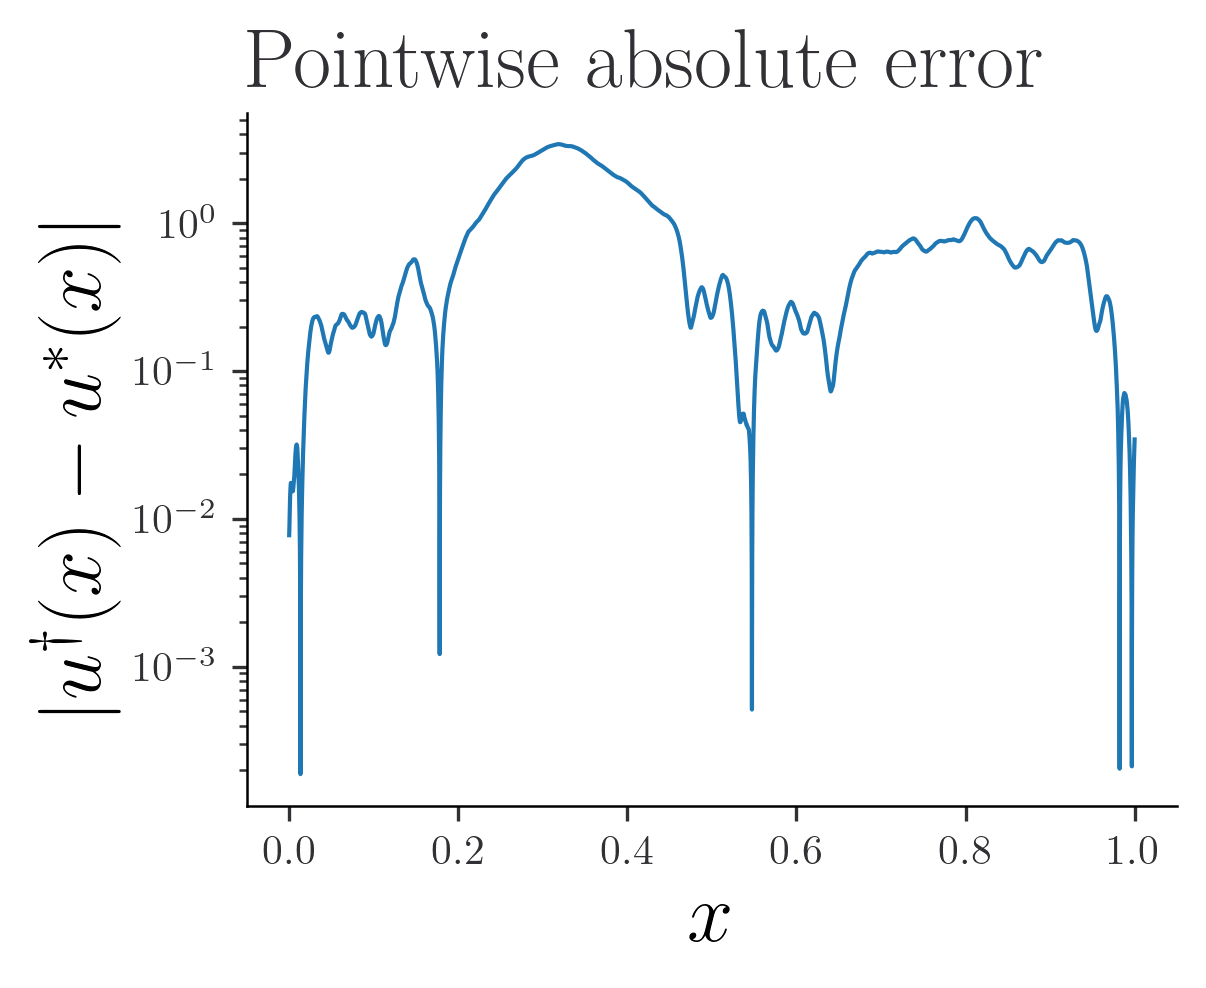

In [ ]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


In [ ]:
pred_transform = discrete_sine_transform(pred)[1:]
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)


1.3196473674330467 1.0603984866814855


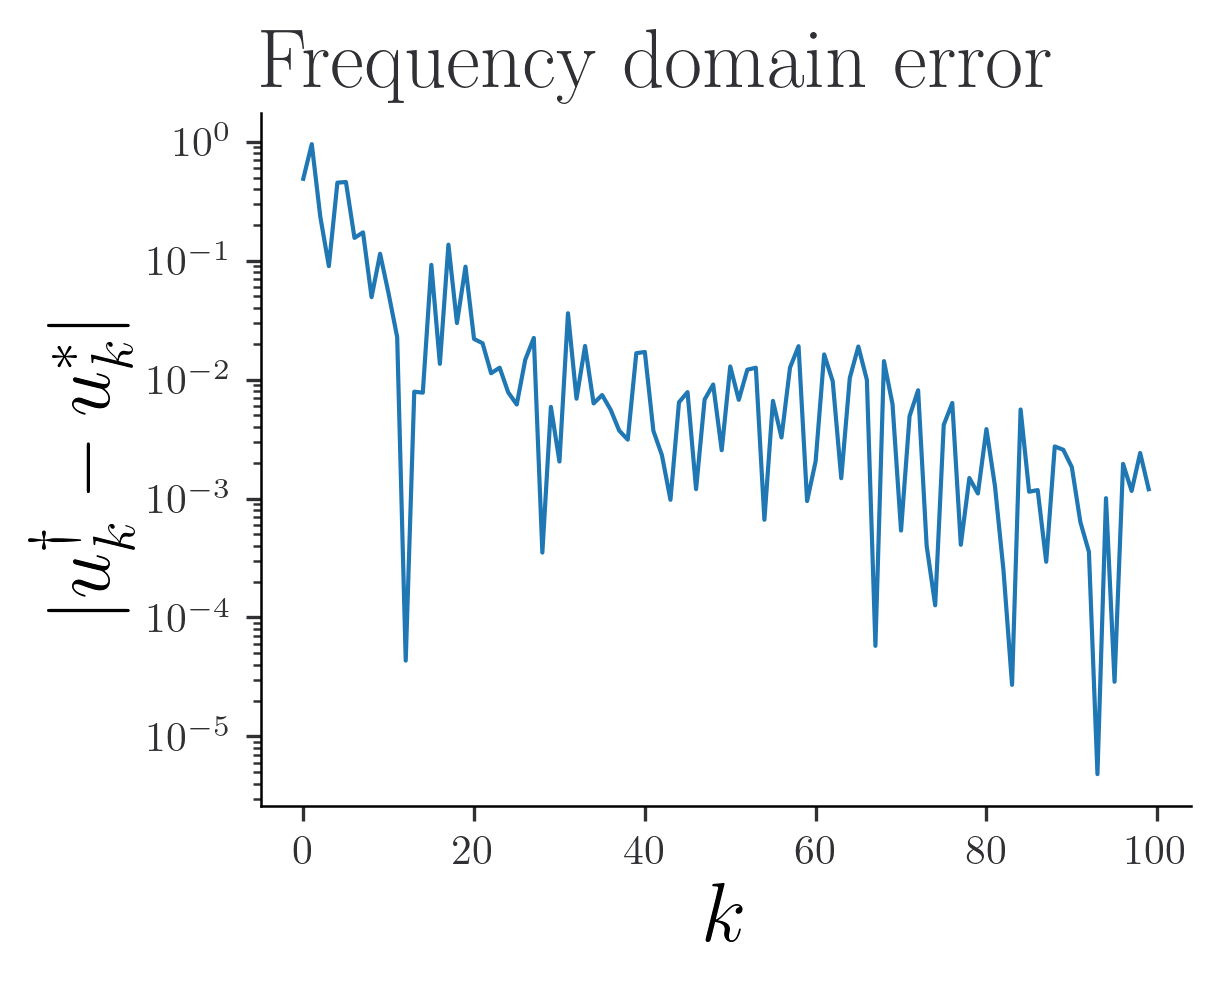

In [ ]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

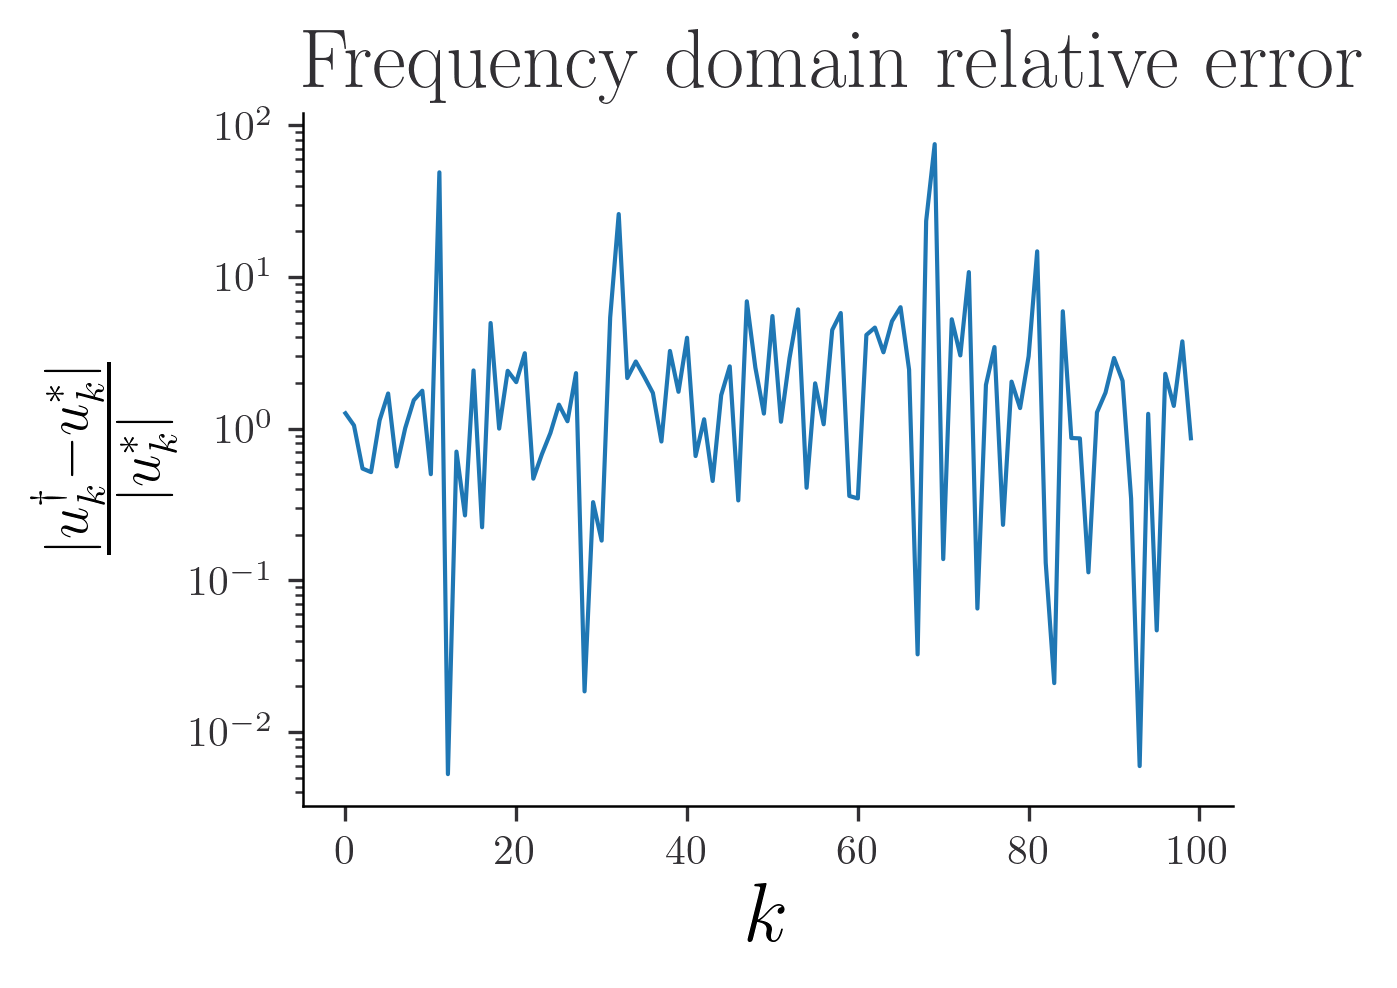

In [ ]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# High-freq PINN 4096 measurements

In [158]:
# Define the neural network
def init_params(layer_sizes, key):
    params = []
    keys = random.split(key, len(layer_sizes))
    for m, n, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        weights = random.normal(key, (m, n)) * jnp.sqrt(2 / m)
        biases = jnp.zeros(n)
        params.append((weights, biases))
    return params

In [159]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1)
domain_measurements.shape

4096


(4097,)

In [160]:
n_samples = 1024
print('Number of samples: ', n_samples)
d_in = 1
nu = 2.5
key = random.PRNGKey(0)
key, subkey = random.split(key)
random_features = random.t(subkey, df  = nu*2, shape = (n_samples, d_in))

Number of samples:  1024


In [161]:
def feature_map(x, random_features):
    n_samples = random_features.shape[0]
    outputs = jnp.dot(random_features, x)
    return jnp.squeeze((1/jnp.sqrt(n_samples))*jnp.vstack([jnp.cos(outputs), jnp.sin(outputs)]))


In [162]:
feature_map(domain_measurements[50], random_features).shape

(2048,)

In [163]:

def predict(params, x):
    activations = x
    # First pass through the feature map
    activations = feature_map(activations, random_features)
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)


In [164]:
layer_sizes = [n_samples*2, 512, 512, 1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)

print("There are {count_parameters(params)} parameters in the neural network.")

neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

In [165]:
predict(params, domain_measurements[0]), neural_network(params, domain_measurements).shape

(Array(0.00362248, dtype=float64), (4097,))

In [166]:
# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w =1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = discrete_sine_transform(-nu*laplacian_grid + u_grid)[1:]
    residual_interior = pred_sine - f

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

In [167]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, coef_f[:n_meas],boundary_conditions, nu, w = 0.5)
print(loss, grads)

() ()
(4097,) (4097,)
0.4924613627799138 [(Array([[-1.64587573e-05,  2.32447738e-05,  5.83477284e-06, ...,
        -5.66096126e-06,  6.53851285e-06,  1.15907157e-06],
       [ 2.31096721e-04, -3.25761541e-04, -8.21518311e-05, ...,
         7.88008630e-05, -9.03193440e-05, -1.58341064e-05],
       [-2.21186043e-04,  3.11845627e-04,  7.86006209e-05, ...,
        -7.55036733e-05,  8.66154034e-05,  1.52098143e-05],
       ...,
       [ 1.53336389e-04, -2.16168975e-04, -5.44971223e-05, ...,
         5.23196277e-05, -5.99986826e-05, -1.05299232e-05],
       [ 1.59716040e-04, -2.25163066e-04, -5.67644720e-05, ...,
         5.44965363e-05, -6.24953046e-05, -1.09680993e-05],
       [ 1.33437652e-04, -1.88115787e-04, -4.74250092e-05, ...,
         4.55297552e-05, -5.22118021e-05, -9.16327889e-06]],      dtype=float64), Array([-7.13744526e-03,  1.00629234e-02,  2.53636502e-03, -7.06400094e-04,
        4.89159317e-03, -5.24711710e-03, -1.39897309e-03, -2.13399570e-03,
        3.47854485e-03,  8.00

In [168]:
# Define the optimizer
optimizer = optax.adamw(1e-3, weight_decay = 0.0)
opt_state = optimizer.init(params)

In [171]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, coef_f[:n_meas],boundary_conditions, nu, w = 0.1)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [172]:
patience = 1000  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

In [173]:
loss_hist = []
num_epochs = 1e5
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')
    loss_hist.append(loss)

    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

Epoch 0, Loss: 0.1003
Early stopping at epoch 9591


In [174]:
pred = neural_network(params, domain_finest)

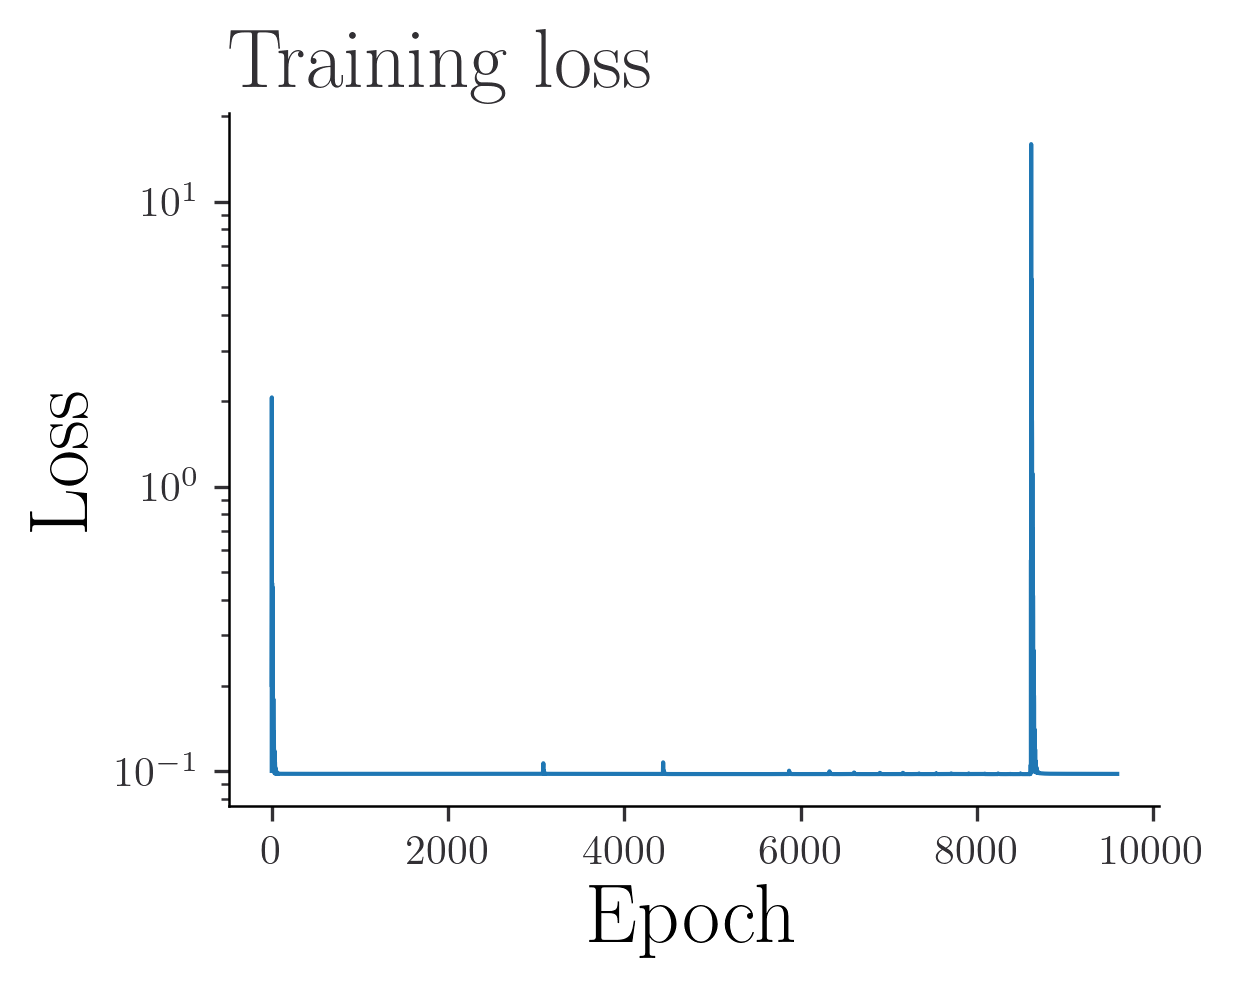

In [175]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

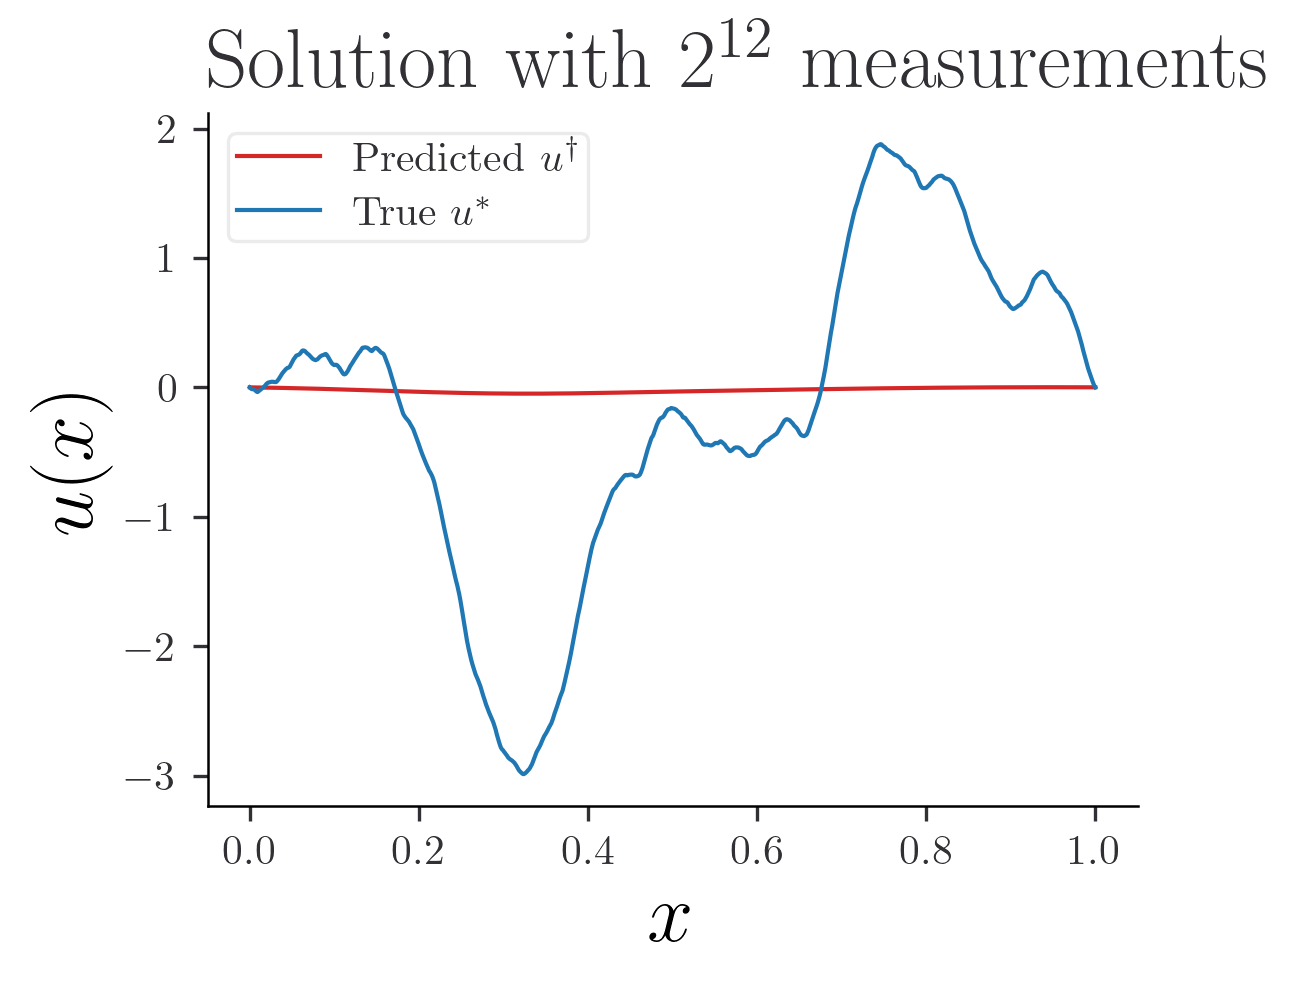

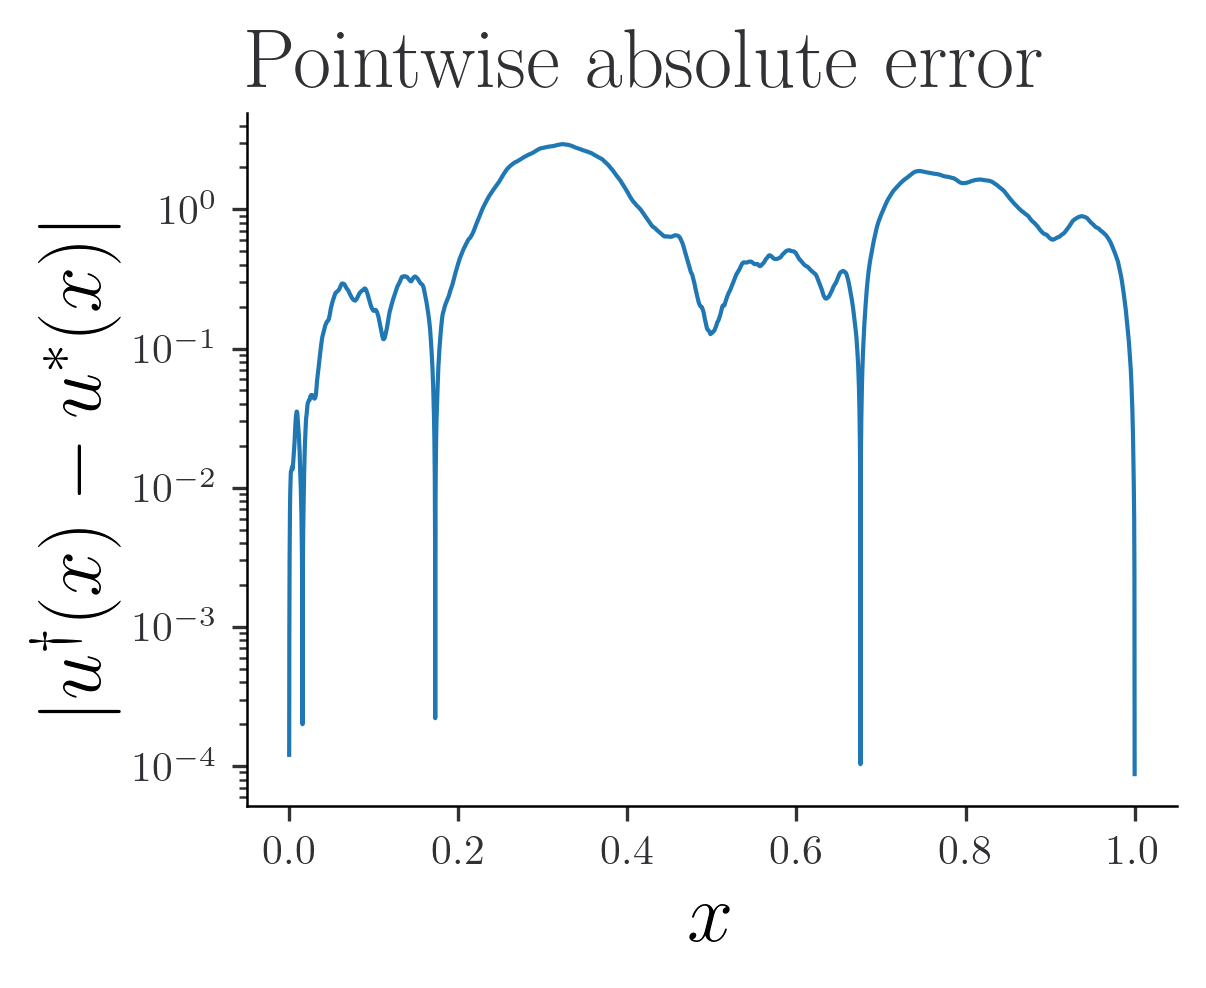

In [180]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
#plt.title(r"Function $u$")
plt.title(r"Solution with $2^{"+str(12)+"}$ measurements")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


In [181]:
pred_transform = discrete_sine_transform(pred)[1:]
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)


1.2456186385822197 1.0009129347214436


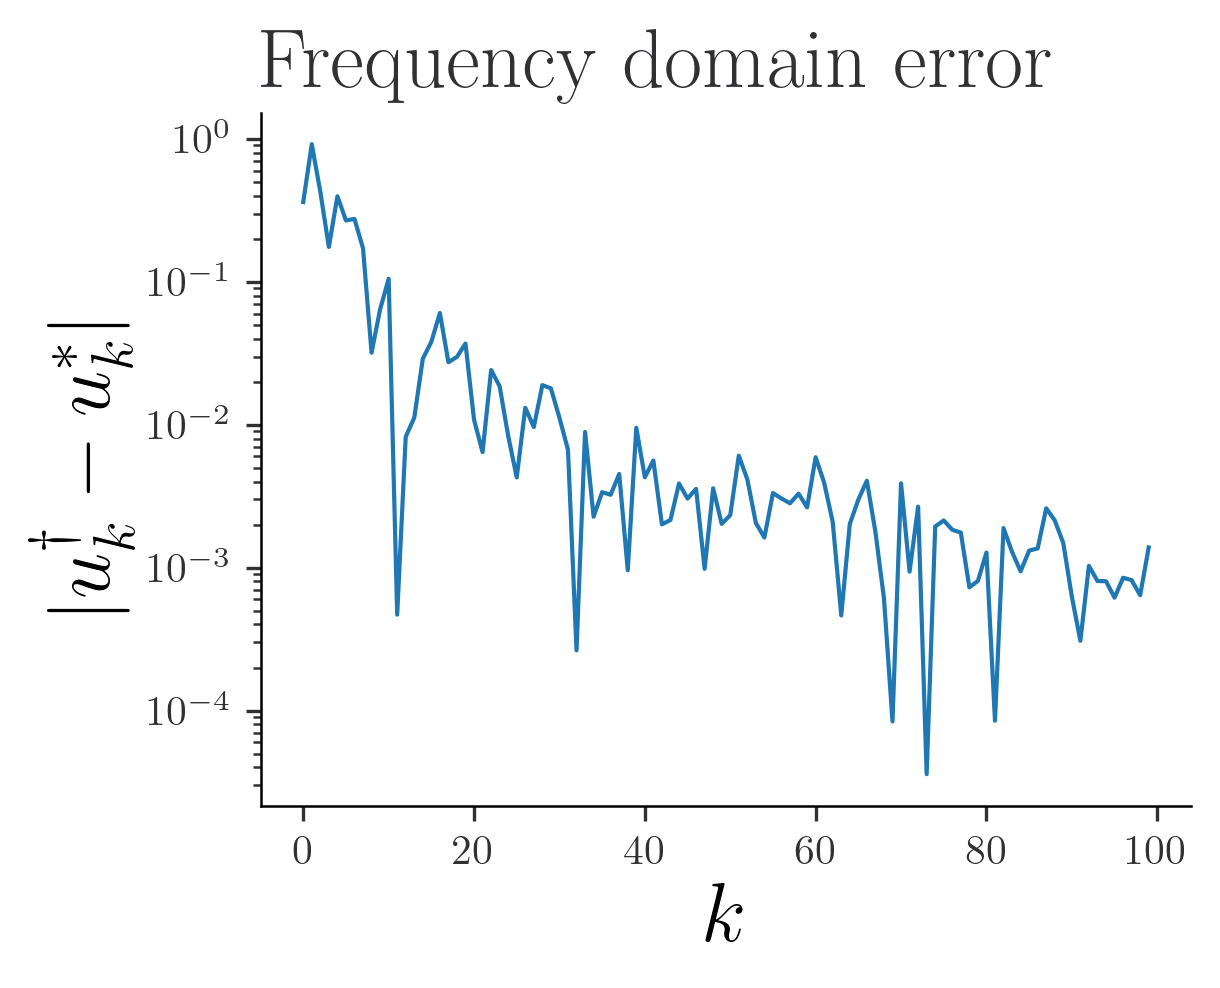

In [182]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

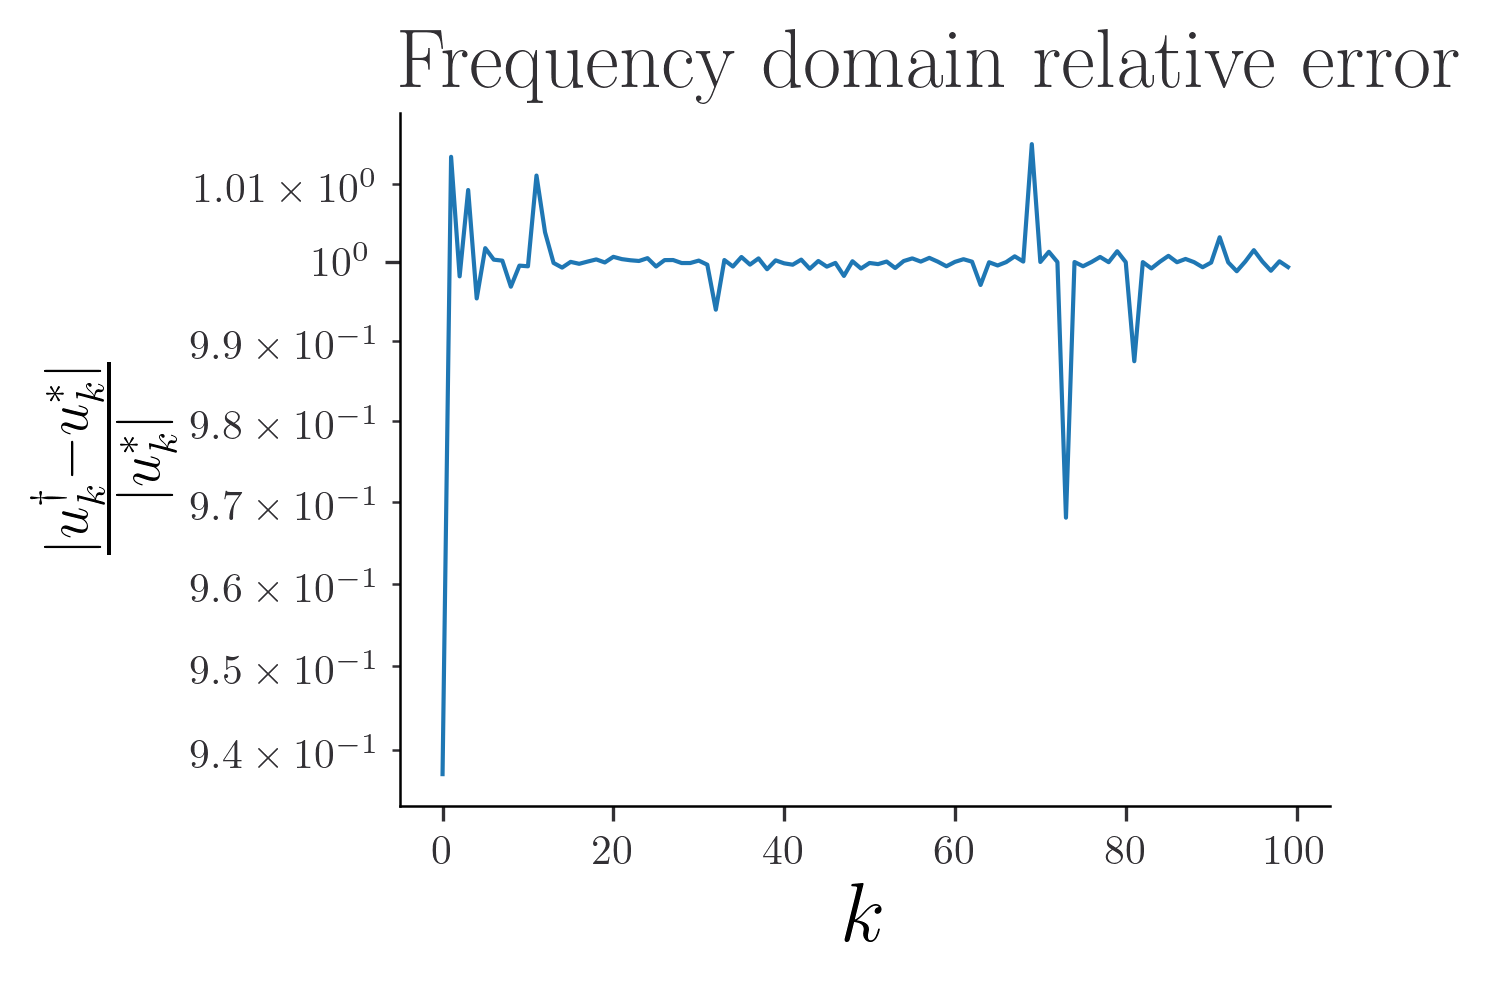

In [183]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()